In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import visual_behavior.data_access.loading as loading
import visual_behavior.data_access.utilities as utilities

import visual_behavior.visualization.utils as utils

experience_level_colors = utils.get_experience_level_colors()
cre_line_colors = utils.get_cre_line_colors()

experience_levels = utils.get_new_experience_levels()
cell_types = utils.get_cell_types()

import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 1})

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from visual_behavior.dimensionality_reduction.clustering import plotting
from visual_behavior.dimensionality_reduction.clustering import processing

import visual_behavior.visualization.ophys.platform_paper_figures as ppf

c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


In [4]:
# !python -m pip install git+https://github.com/nirum/jetplot


In [5]:
import jetplot
import matplotlib.colors


## get experiment and cell metadata

In [6]:
# load experiments table
experiments_table = loading.get_platform_paper_experiment_table(limit_to_closest_active=True)
# limit to closest familiar and novel active
experiments_table = utilities.limit_to_last_familiar_second_novel_active(experiments_table)
experiments_table = utilities.limit_to_containers_with_all_experience_levels(experiments_table)

# load matched cells table
cells_table = loading.get_cell_table()
cells_table = loading.get_matched_cells_table(cells_table)
matched_cells = cells_table.cell_specimen_id.unique()
matched_experiments = cells_table.ophys_experiment_id.unique()

# get cre_lines and cell types for plot labels
cre_lines = np.sort(cells_table.cre_line.unique())
cell_types = utilities.get_cell_types_dict(cre_lines, experiments_table)

removing 1 problematic experiments


c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


removing 1 problematic experiments
3921 cells in matched cells table


In [7]:
base_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4'

save_dir = os.path.join(base_dir, 'all_cre_clustering_113023')
folder = 'figs'

## load GLM results

### get GLM results (not across session normalized)

In [8]:
import visual_behavior_glm.GLM_fit_dev as gfd
import visual_behavior_glm.GLM_analysis_tools as gat

In [9]:
glm_version = '24_events_all_L2_optimize_by_session'

run_params, all_results, all_results_pivoted, weights_df = gfd.load_analysis_dfs(glm_version)

loading run_params
loading results df
loading results_pivoted df
loading weights_df


### get across session normalized dropout scores

In [10]:
import visual_behavior_glm.GLM_across_session as gas

glm_version = '24_events_all_L2_optimize_by_session'

# get across session normalized dropout scores
across_results, failed_cells = gas.load_cells(glm_version, clean_df=True)
across_results = across_results.set_index('identifier')

Loading list of matched cells


c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


removing 1 problematic experiments
Loading across session normalized dropout scores


100%|██████████████████████████████████████████████████████████████████████████████| 3921/3921 [04:14<00:00, 15.43it/s]


0 cells could not be loaded


In [11]:
# cell_list = gas.get_cell_list(glm_version)

In [12]:
# only use across session values
across = across_results[[key for key in across_results.keys() if '_across' in key] + ['cell_specimen_id', 'ophys_experiment_id', 'experience_level']]
results_pivoted = across.copy()
# rename across session columns 
results_pivoted = results_pivoted.rename(
    columns={'omissions_across': 'omissions', 'all-images_across': 'all-images',
             'behavioral_across': 'behavioral', 'task_across': 'task'})
print(len(results_pivoted), 'len(results_pivoted)')

11763 len(results_pivoted)


#### limit GLM results to matched cells and reformat

In [13]:
results_pivoted.head()

,omissions,all-images,behavioral,task,cell_specimen_id,ophys_experiment_id,experience_level
identifier,,,,,,,
794381992_1086551315,0.0,0.000000,0.0,0.000000,1086551315,794381992,Familiar
795076128_1086551315,0.0,-0.295018,0.0,-0.094833,1086551315,795076128,Novel 1
796105304_1086551315,0.0,-0.258126,0.0,-0.430496,1086551315,796105304,Novel >1
794381992_1086550804,0.0,0.000000,0.0,0.000000,1086550804,794381992,Familiar
795076128_1086550804,0.0,0.000000,0.0,0.000000,1086550804,795076128,Novel 1


In [14]:
# limit to matched cells 
results_pivoted = results_pivoted[results_pivoted.ophys_experiment_id.isin(matched_experiments)]
results_pivoted = results_pivoted[results_pivoted.cell_specimen_id.isin(matched_cells)]

# drop duplicates
results_pivoted = results_pivoted.drop_duplicates(subset=['cell_specimen_id', 'experience_level'])
print(len(results_pivoted), 'len(results_pivoted) after dropping duplicates')
        
print(len(results_pivoted.cell_specimen_id.unique()),
      'cells in results_pivoted after limiting to strictly matched cells')

11763 len(results_pivoted) after dropping duplicates
3921 cells in results_pivoted after limiting to strictly matched cells


In [15]:
results_pivoted.head()

,omissions,all-images,behavioral,task,cell_specimen_id,ophys_experiment_id,experience_level
identifier,,,,,,,
794381992_1086551315,0.0,0.000000,0.0,0.000000,1086551315,794381992,Familiar
795076128_1086551315,0.0,-0.295018,0.0,-0.094833,1086551315,795076128,Novel 1
796105304_1086551315,0.0,-0.258126,0.0,-0.430496,1086551315,796105304,Novel >1
794381992_1086550804,0.0,0.000000,0.0,0.000000,1086550804,794381992,Familiar
795076128_1086550804,0.0,0.000000,0.0,0.000000,1086550804,795076128,Novel 1


In [16]:
# limit to features used for clustering
# features = processing.get_features_for_clustering()
features = ['all-images', 'omissions', 'task', 'behavioral']
features = [*features, 'ophys_experiment_id']
results_pivoted = processing.limit_results_pivoted_to_features_for_clustering(results_pivoted, features)

# flip sign so coding scores are positive
results_pivoted = processing.flip_sign_of_dropouts(results_pivoted, processing.get_features_for_clustering(), use_signed_weights=False)

# now drop ophys_experiment_id
results_pivoted = results_pivoted.drop(columns=['ophys_experiment_id'])

In [17]:
results_pivoted.head()

,all-images,omissions,task,behavioral,cell_specimen_id,experience_level
identifier,,,,,,
794381992_1086551315,0.000000,0.0,0.000000,0.0,1086551315,Familiar
795076128_1086551315,0.295018,0.0,0.094833,0.0,1086551315,Novel 1
796105304_1086551315,0.258126,0.0,0.430496,0.0,1086551315,Novel >1
794381992_1086550804,0.000000,0.0,0.000000,0.0,1086550804,Familiar
795076128_1086550804,0.000000,0.0,0.000000,0.0,1086550804,Novel 1


### replace old experience level with new one (Novel+)

In [18]:
cells_table['experience_level'] = [utils.convert_experience_level(experience_level) for experience_level in cells_table.experience_level.values]

In [19]:
results_pivoted['experience_level'] = [utils.convert_experience_level(experience_level) for experience_level in results_pivoted.experience_level.values]


## load or generate clustering results


In [20]:
feature_matrix = processing.get_feature_matrix_for_clustering(results_pivoted, glm_version, save_dir=save_dir)

No duplicated cells found
3921


C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\pandas\io\pytables.py:314: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->integer,key->axis1] [items->None]

  f(store)


In [21]:
cell_metadata = processing.get_cell_metadata_for_feature_matrix(feature_matrix, cells_table)

3921 cells in cell_metadata for feature_matrix


In [22]:
n_clusters = 14 # empirically determined, then validated based on within vs. across cluster variance

cluster_meta = processing.run_all_cre_clustering(feature_matrix, cells_table, n_clusters, save_dir, folder)


3921 cells in cell_metadata for feature_matrix


In [23]:
cluster_meta.experience_level.unique()

array(['Familiar', 'Novel'], dtype=object)

<AxesSubplot:title={'center':'within cluster correlation'}, xlabel='cluster #', ylabel='correlation'>

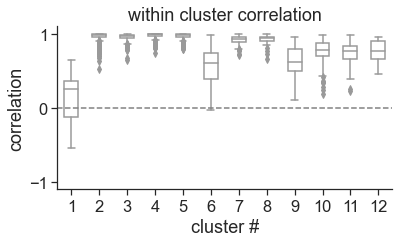

In [24]:
# plot within cluster correlations distribution
plotting.plot_within_cluster_correlations(cluster_meta, sort_order=None, spearman=False, suffix='_'+str(n_clusters)+'_clusters',
                                                save_dir=save_dir, folder=folder, ax=None)

## load multi session response dataframes

In [25]:
data_type = 'events'

interpolate = True
output_sampling_rate = 30

# set inclusion criteria
# options: ['active_only', 'closest_familiar_and_novel', 'containers_with_all_levels']


inclusion_criteria = 'platform_experiment_table'

In [26]:
# params for stim response df creation
event_type = 'all'

# params for mean response df creation
conditions = ['cell_specimen_id', 'is_change']


change_suffix = '_'+utils.get_conditions_string(data_type, conditions)+'_'+inclusion_criteria

multi_session_df = loading.get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria, 
                                                        interpolate=interpolate, output_sampling_rate=output_sampling_rate, 
                                                         epoch_duration_mins=None)

# limit to changes, convert experience level and merge with cluster IDs
change_mdf = multi_session_df[multi_session_df.is_change==True]
change_mdf['experience_level'] = [utils.convert_experience_level(experience_level) for experience_level in change_mdf.experience_level.values]
change_mdf = change_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

# limit to non-changes, convert experience level and merge with cluster IDs
image_mdf = multi_session_df[(multi_session_df.is_change==False)]
image_mdf['experience_level'] = [utils.convert_experience_level(experience_level) for experience_level in image_mdf.experience_level.values]
image_mdf = image_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


loading files from \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz
mean_response_df_events_all_is_change_platform_experiment_table.pkl
loading multi_session_df from saved file at \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz\mean_response_df_events_all_is_change_platform_experiment_table.pkl
there are 1249 experiments in the full multi_session_df


c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


removing 1 problematic experiments
there are 402 experiments in the multi_session_df after limiting to platform experiments
there are 402 experiments after filtering for inclusion criteria -  platform_experiment_table


C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [27]:
# params for stim response df creation
event_type = 'all'

# params for mean response df creation
conditions = ['cell_specimen_id', 'omitted']


change_suffix = '_'+utils.get_conditions_string(data_type, conditions)+'_'+inclusion_criteria

omission_mdf = loading.get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria, 
                                                        interpolate=interpolate, output_sampling_rate=output_sampling_rate, 
                                                         epoch_duration_mins=None)

omission_mdf = omission_mdf[omission_mdf.omitted==True]
omission_mdf['experience_level'] = [utils.convert_experience_level(experience_level) for experience_level in omission_mdf.experience_level.values]
omission_mdf = omission_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


loading files from \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz
mean_response_df_events_all_omitted_platform_experiment_table.pkl
loading multi_session_df from saved file at \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz\mean_response_df_events_all_omitted_platform_experiment_table.pkl
there are 1249 experiments in the full multi_session_df


c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


removing 1 problematic experiments
there are 402 experiments in the multi_session_df after limiting to platform experiments
there are 402 experiments after filtering for inclusion criteria -  platform_experiment_table


In [28]:
image_mdf.head()

,cell_specimen_id,is_change,mean_response,sem_response,mean_trace,sem_trace,trace_timestamps,mean_responses,mean_baseline,sem_baseline,...,area_layer,date,first_novel,n_relative_to_first_novel,last_familiar,last_familiar_active,second_novel,second_novel_active,experience_exposure,cluster_id
0,1086512525,False,0.000378,0.000085,"[0.0002609137937950352, 0.00025595230420912896...","[0.00020663754053138245, 0.0002051420987133595...","[-2.0, -1.9666666666665331, -1.933333333333310...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000489,0.000096,...,VISp_upper,20190521,False,-1.0,True,True,False,False,Familiar 2,1
1,1086512525,False,0.010691,0.001032,"[0.020750895303695963, 0.020026680218746575, 0...","[0.002318892182453525, 0.0022168451789626536, ...","[-2.0, -1.9666666666665262, -1.933333333333319...","[0.0, 0.08849171995997765, 0.0, 0.0, 0.6038463...",0.008674,0.000848,...,VISp_upper,20190522,True,0.0,False,False,False,False,Novel 0,1
2,1086512525,False,0.000587,0.000127,"[0.0008702936768878897, 0.0007953335862437194,...","[0.00039898978045473115, 0.0003733288775475275...","[-2.0, -1.96666666666654, -1.9333333333333014,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000595,0.000152,...,VISp_upper,20190528,False,1.0,False,False,True,True,Novel 1,1
3,1086512796,False,0.003072,0.000401,"[0.001845323171697168, 0.002069146081047714, 0...","[0.0005718234452260299, 0.0005687246814664766,...","[-2.0, -1.9666666666665331, -1.933333333333310...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.003487,0.000409,...,VISp_upper,20190521,False,-1.0,True,True,False,False,Familiar 2,11
4,1086512796,False,0.030150,0.001722,"[0.04402635985928799, 0.04195337910549092, 0.0...","[0.003310211459690617, 0.0031458509072864282, ...","[-2.0, -1.9666666666665262, -1.933333333333319...","[0.7791366072731403, 0.8461768667893224, 0.773...",0.022582,0.001334,...,VISp_upper,20190522,True,0.0,False,False,False,False,Novel 0,11


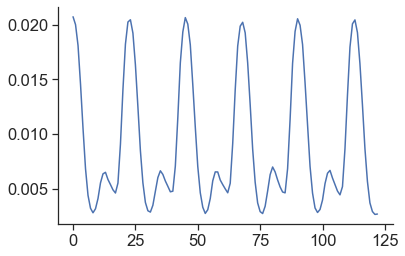

In [29]:
plt.plot(image_mdf.iloc[1].mean_trace)

In [30]:
image_mdf.experience_level.unique()

array(['Familiar', 'Novel', 'Novel +'], dtype=object)

## main cluster plots

### heatmaps

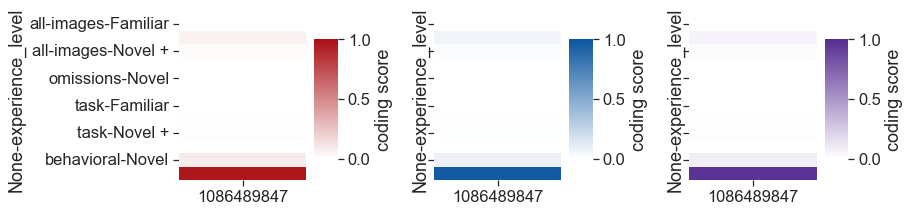

In [31]:
figsize= (12,3)
fig, ax = plt.subplots(1, 3, figsize=figsize, sharey=True)
colors = experience_level_colors.copy()
for i in range (0,3): 
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", colors[i]])
    ax[i] = sns.heatmap(pd.DataFrame(feature_matrix.iloc[0]), vmin=0, vmax=1,
                        cmap=cmap, cbar_kws={'aspect':5, 'label':'coding score'}, ax=ax[i])
plt.subplots_adjust(wspace=0.6)

C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\pandas\core\frame.py:9203: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  validate=validate,


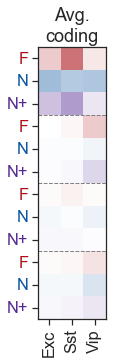

In [32]:
plotting.plot_cre_line_means_remapped(feature_matrix, cluster_meta, save_dir, folder)

<AxesSubplot:title={'center':'Cluster averages'}, xlabel='Cluster ID'>

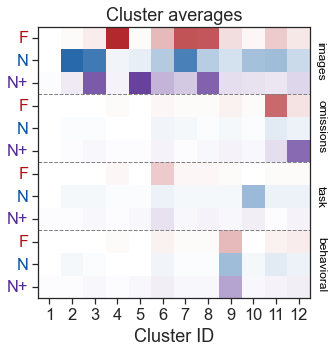

In [33]:
plotting.plot_cluster_means_remapped(feature_matrix, cluster_meta, save_dir=save_dir, folder=folder, ax=None)

In [34]:
# plot_cluster_means_remapped(feature_matrix, cluster_meta, orient='horiz', save_dir=save_dir, folder=folder, ax=None)

<AxesSubplot:xlabel='cells'>

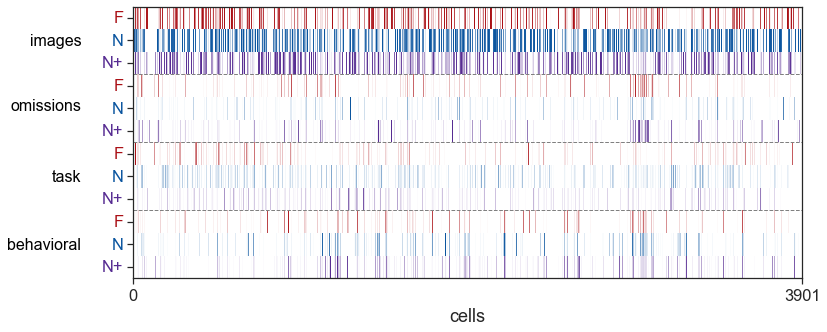

In [35]:
cluster_meta_tmp = cluster_meta.copy()
cluster_meta_tmp['cell_index'] = cluster_meta_tmp.index.values
plotting.plot_coding_score_heatmap_remapped(cluster_meta_tmp, feature_matrix, sort_by=None, session_colors=True,
                                    save_dir=save_dir, folder=folder, ax=None)

<AxesSubplot:xlabel='Cluster ID'>

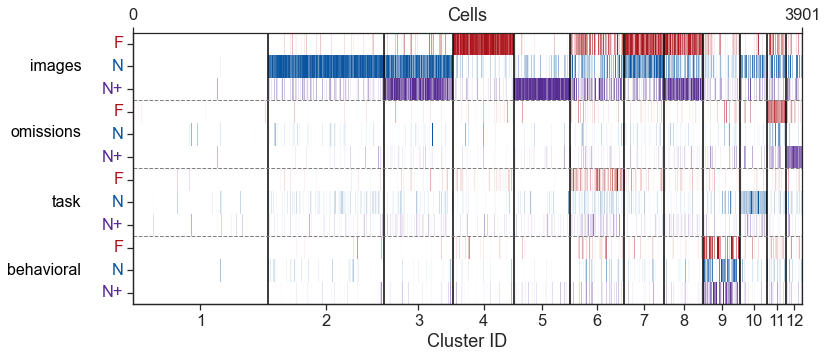

In [36]:
plotting.plot_coding_score_heatmap_remapped(cluster_meta, feature_matrix, sort_by='cluster_id', session_colors=True,
                                    save_dir=save_dir, folder=folder, ax=None)

<AxesSubplot:title={'center':'Cluster averages'}, xlabel='Cluster ID'>

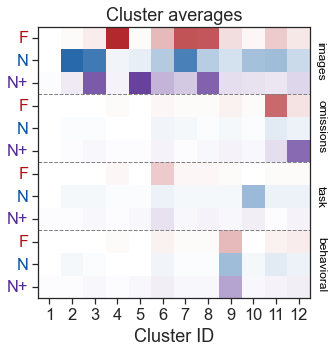

In [37]:
plotting.plot_cluster_means_remapped(feature_matrix, cluster_meta, save_dir=save_dir, folder=folder, ax=None)

### fraction cells per cluster per cre

12 12
8 12
10 12


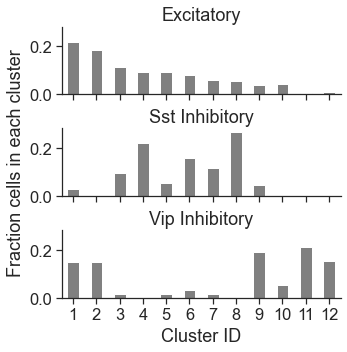

In [38]:
plotting.plot_fraction_cells_per_cluster_per_cre(cluster_meta, col_to_group='cre_line', 
                                                    save_dir=save_dir, folder=folder)

In [39]:
cell_counts = cluster_meta.groupby(['cell_type']).count().rename(columns={'cre_line':'n_cells'})[['n_cells']]
cell_counts

,n_cells
cell_type,
Excitatory,3298
Sst Inhibitory,194
Vip Inhibitory,409


In [40]:
cell_counts = cluster_meta.reset_index().drop_duplicates(subset='cell_specimen_id').copy()
cell_counts = cell_counts.groupby(['cell_type']).count()
cell_counts

,cell_specimen_id,ophys_experiment_id,cre_line,cluster_id,labels,within_cluster_correlation_p,equipment_name,full_genotype,mouse_id,reporter_line,...,layer,area_layer,date,first_novel,n_relative_to_first_novel,last_familiar,last_familiar_active,second_novel,second_novel_active,experience_exposure
cell_type,,,,,,,,,,,,,,,,,,,,,
Excitatory,3298,3298,3298,3298,3298,2673,3298,3298,3298,3298,...,3298,3298,3298,3298,3298,3298,3298,3298,3298,3298
Sst Inhibitory,194,194,194,194,194,190,194,194,194,194,...,194,194,194,194,194,194,194,194,194,194
Vip Inhibitory,409,409,409,409,409,364,409,409,409,409,...,409,409,409,409,409,409,409,409,409,409


## single cell plots

In [41]:
import visual_behavior.dimensionality_reduction.clustering.single_cell_plots as scp

#### single cell coding heatmap for schematic

<AxesSubplot:>

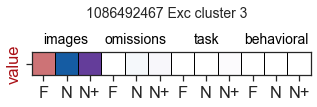

In [42]:
 # get coding scores for this cell

cell_specimen_id = 1086492467 # excitatory cluster 3 cell 
cluster_id = 2
# cell_specimen_id = 1086509065 # Vip cluster 11 cell 

scp.plot_single_cell_coding_heatmap(cluster_id, cell_specimen_id, feature_matrix, cells_table, save_dir=None, folder=None, ax=None)


In [43]:
# for cluster_id in np.sort(cluster_meta.cluster_id.unique()):
#     this_cluster = cluster_meta[cluster_meta.cluster_id==cluster_id]
#     csids = this_cluster.index.unique()
#     cell_roi_ids = cells_table[cells_table.cell_specimen_id.isin(csids)].index.values

#     max_cluster_exp_var = all_results[all_results.cell_roi_id.isin(cell_roi_ids)].sort_values(by='adj_variance_explained_full', ascending=False)
#     max_roi_ids = max_cluster_exp_var.cell_roi_id.values[:50]
#     max_csids = cells_table.loc[max_roi_ids].cell_specimen_id.unique()

#     for cell_specimen_id in max_csids: 
#         plot_single_cell_coding_heatmap(cluster_id, cell_specimen_id, feature_matrix, save_dir=save_dir, folder=folder, ax=None)


### single cell examples from each cluster

<AxesSubplot:title={'center':'cluster 11\nExc cell'}, ylabel='coding score'>

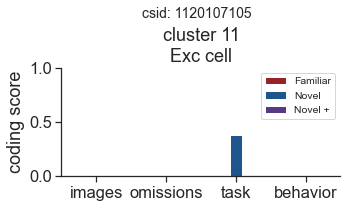

In [44]:
cluster_id = 10
this_cluster = cluster_meta[cluster_meta.cluster_id==cluster_id]
csids = this_cluster.index.unique()
cell_roi_ids = cells_table[cells_table.cell_specimen_id.isin(csids)].index.values

max_cluster_exp_var = all_results[all_results.cell_roi_id.isin(cell_roi_ids)].sort_values(by='adj_variance_explained_full', ascending=False)
max_roi_ids = max_cluster_exp_var.cell_roi_id.values[:50]
max_csids = cells_table.loc[max_roi_ids].cell_specimen_id.unique()

cell_specimen_id = max_csids[0]

scp.plot_coding_scores_example_cell(cluster_id, cell_specimen_id, feature_matrix, cells_table, single_axis=True, save_dir=save_dir, folder=folder, ax=None)

In [45]:
# for cluster_id in np.sort(cluster_meta.cluster_id.unique()):
#     this_cluster = cluster_meta[cluster_meta.cluster_id==cluster_id]
#     csids = this_cluster.index.unique()
#     cell_roi_ids = cells_table[cells_table.cell_specimen_id.isin(csids)].index.values

#     max_cluster_exp_var = all_results[all_results.cell_roi_id.isin(cell_roi_ids)].sort_values(by='adj_variance_explained_full', ascending=False)
#     max_roi_ids = max_cluster_exp_var.cell_roi_id.values[:50]
#     max_csids = cells_table.loc[max_roi_ids].cell_specimen_id.unique()

#     for cell_specimen_id in max_csids: 
#         plot_coding_scores_example_cell(cluster_id, cell_specimen_id, feature_matrix, single_axis=True, save_dir=save_dir, folder=folder, ax=None)

### mean response examples

In [46]:
image_responses = image_mdf.copy()
change_responses = change_mdf.copy()
omission_responses = omission_mdf.copy()

array([<AxesSubplot:title={'center':'images'}, xlabel='time (s)', ylabel='response'>,
       <AxesSubplot:title={'center':'omissions'}, xlabel='time (s)'>,
       <AxesSubplot:title={'center':'changes'}, xlabel='time (s)'>],
      dtype=object)

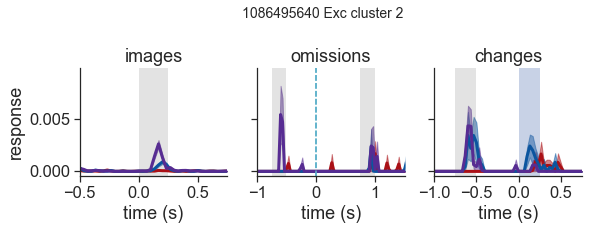

In [47]:
cluster_id = 1

this_cluster = cluster_meta[cluster_meta.cluster_id==cluster_id]
csids = this_cluster.index.unique()
cell_roi_ids = cells_table[cells_table.cell_specimen_id.isin(csids)].index.values

max_cluster_exp_var = all_results[all_results.cell_roi_id.isin(cell_roi_ids)].sort_values(by='adj_variance_explained_full', ascending=True)
max_roi_ids = max_cluster_exp_var.cell_roi_id.values[50:100]
max_csids = cells_table.loc[max_roi_ids].cell_specimen_id.unique()

cell_specimen_id = max_csids[0]
    
scp.plot_matched_cell_traces(cluster_id, cell_specimen_id, image_responses, omission_responses, change_responses, cells_table, save_dir=save_dir, folder=folder, ax=None)

In [48]:
# cluster_id = 10

# this_cluster = cluster_meta[cluster_meta.cluster_id==cluster_id]
# csids = this_cluster.index.unique()
# cell_roi_ids = cells_table[cells_table.cell_specimen_id.isin(csids)].index.values

# max_cluster_exp_var = all_results[all_results.cell_roi_id.isin(cell_roi_ids)].sort_values(by='adj_variance_explained_full', ascending=True)
# max_roi_ids = max_cluster_exp_var.cell_roi_id.values[50:100]
# max_csids = cells_table.loc[max_roi_ids].cell_specimen_id.unique()

# for cell_specimen_id in max_csids:
    
#     plot_matched_cell_traces(cluster_id, cell_specimen_id, image_responses, omission_responses, change_responses, cells_table, save_dir=save_dir, folder=folder, ax=None)

In [49]:
# omission_responses = omission_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
# omission_responses = omission_responses[omission_responses.omitted==True]
# image_responses = image_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
# image_responses = image_responses[image_responses.is_change==False]
# change_responses = change_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
# change_responses = change_responses[change_responses.is_change==True]


# for cluster_id in np.sort(cluster_meta.cluster_id.unique()):
#     this_cluster = cluster_meta[cluster_meta.cluster_id==cluster_id]
#     csids = this_cluster.index.unique()
#     cell_roi_ids = cells_table[cells_table.cell_specimen_id.isin(csids)].index.values

#     max_cluster_exp_var = all_results[all_results.cell_roi_id.isin(cell_roi_ids)].sort_values(by='adj_variance_explained_full', ascending=False)
#     max_roi_ids = max_cluster_exp_var.cell_roi_id.values[:50]
#     max_csids = cells_table.loc[max_roi_ids].cell_specimen_id.unique()
#     for cell_specimen_id in max_csids:
        
#         plot_matched_cell_traces(cluster_id, cell_specimen_id, image_responses, omission_responses, change_responses, cells_table, save_dir=save_dir, folder=folder, ax=None)

### matched ROIs

Note, this function is very slow because it has to load each dataset from NWb

In [50]:
# cluster_id = 1

# this_cluster = cluster_meta[cluster_meta.cluster_id==cluster_id]
# csids = this_cluster.index.unique()
# cell_roi_ids = cells_table[cells_table.cell_specimen_id.isin(csids)].index.values

# max_cluster_exp_var = all_results[all_results.cell_roi_id.isin(cell_roi_ids)].sort_values(by='adj_variance_explained_full', ascending=False)
# max_roi_ids = max_cluster_exp_var.cell_roi_id.values[:50]
# max_csids = cells_table.loc[max_roi_ids].cell_specimen_id.unique()

# cell_specimen_id = max_csids[0]

# scp.plot_matched_cell_rois(cluster_id, cell_specimen_id, cells_table, save_dir=save_dir, folder=folder, ax=None)

In [51]:

# for cluster_id in np.sort(cluster_meta.cluster_id.unique()):
#     this_cluster = cluster_meta[cluster_meta.cluster_id==cluster_id]
#     csids = this_cluster.index.unique()
#     cell_roi_ids = cells_table[cells_table.cell_specimen_id.isin(csids)].index.values

#     max_cluster_exp_var = results[results.cell_roi_id.isin(cell_roi_ids)].sort_values(by='adj_variance_explained_full', ascending=False)
#     max_roi_ids = max_cluster_exp_var.cell_roi_id.values[:50]
#     max_csids = cells_table.loc[max_roi_ids].cell_specimen_id.unique()
#     for cell_specimen_id in max_csids:
        
#         plot_matched_cell_rois(cluster_id, cell_specimen_id, cells_table, save_dir=save_dir, folder=folder, ax=None)

## cluster properties

### area / depth proportions for cre lines (this should actually be in figure 2)

In [52]:
cre_stats = processing.get_cre_line_stats_for_locations(cluster_meta, location='layer')
cre_stats

n_cells_location  n_cells_total  \
cre_line          layer                                    
Slc17a7-IRES2-Cre lower              1863           3298   
                  upper              1435           3298   
Sst-IRES-Cre      lower               119            194   
                  upper                75            194   
Vip-IRES-Cre      lower                24            409   
                  upper               385            409   

                         fraction_cells_location  
cre_line          layer                           
Slc17a7-IRES2-Cre lower                 0.564888  
                  upper                 0.435112  
Sst-IRES-Cre      lower                 0.613402  
                  upper                 0.386598  
Vip-IRES-Cre      lower                 0.058680  
                  upper                 0.941320

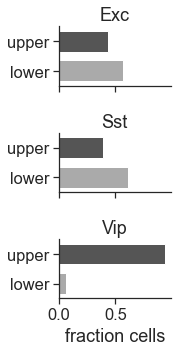

In [53]:
location = 'layer'
order = ['upper', 'lower']
cre_stats = processing.get_cre_line_stats_for_locations(cluster_meta, location)

metric = 'fraction_cells_location'
xlabel = 'fraction cells'

plotting.plot_location_distribution_for_cre_lines(cre_stats, location=location, order=order,
                                            metric=metric, xlabel=xlabel,
                                            sharex=True, ax=None, save_dir=save_dir, folder=folder);


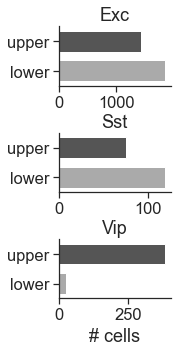

In [54]:
location = 'layer'
order = ['upper', 'lower']
cre_stats = processing.get_cre_line_stats_for_locations(cluster_meta, location)

metric = 'n_cells_location'
xlabel = '# cells'

plotting.plot_location_distribution_for_cre_lines(cre_stats, location=location, order=order,
                                            metric=metric, xlabel=xlabel,
                                            sharex=False, ax=None, save_dir=save_dir, folder=folder);


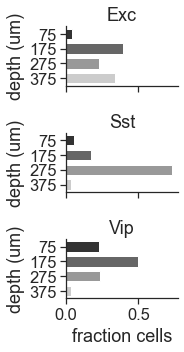

In [55]:
location = 'binned_depth'
order = None
ylabel = 'depth (um)'
cre_stats = processing.get_cre_line_stats_for_locations(cluster_meta, location)

metric = 'fraction_cells_location'
xlabel = 'fraction cells'


plotting.plot_location_distribution_for_cre_lines(cre_stats, location=location, order=order,
                                            metric=metric, xlabel=xlabel, ylabel=ylabel,
                                            sharex=True, ax=None, save_dir=save_dir, folder=folder);


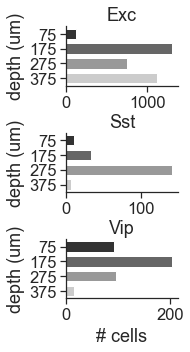

In [56]:
location = 'binned_depth'
order = None
ylabel = 'depth (um)'
cre_stats = processing.get_cre_line_stats_for_locations(cluster_meta, location)

metric = 'n_cells_location'
xlabel = '# cells'


plotting.plot_location_distribution_for_cre_lines(cre_stats, location=location, order=order,
                                            metric=metric, xlabel=xlabel, ylabel=ylabel,
                                            sharex=False, ax=None, save_dir=save_dir, folder=folder);


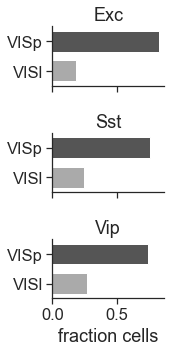

In [57]:
location = 'targeted_structure'
order = ['VISp', 'VISl']
cre_stats = processing.get_cre_line_stats_for_locations(cluster_meta, location)

metric = 'fraction_cells_location'
xlabel = 'fraction cells'

plotting.plot_location_distribution_for_cre_lines(cre_stats, location=location, order=order,
                                            metric=metric, xlabel=xlabel,
                                            sharex=True, ax=None, save_dir=save_dir, folder=folder);


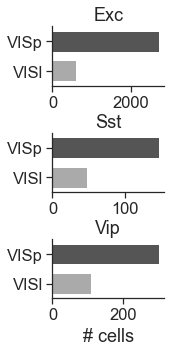

In [58]:
location = 'targeted_structure'
order = ['VISp', 'VISl']
cre_stats = processing.get_cre_line_stats_for_locations(cluster_meta, location)

metric = 'n_cells_location'
xlabel = '# cells'

plotting.plot_location_distribution_for_cre_lines(cre_stats, location=location, order=order,
                                            metric=metric, xlabel=xlabel,
                                            sharex=False, ax=None, save_dir=save_dir, folder=folder);


### population average response per cluster

#### all cell types together

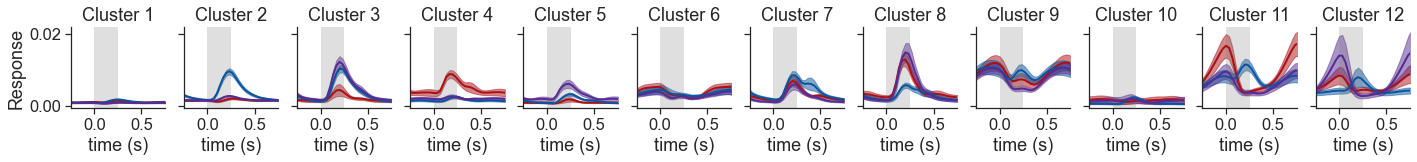

In [59]:
# tmp = image_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
tmp = image_mdf.copy()
tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.8))]

xlim_seconds = [-0.25, 0.75]
timestamps = tmp.trace_timestamps.values[0]

axes_column = 'cluster_id'
hue_column = 'experience_level'

plotting.plot_population_averages_for_clusters(tmp, event_type, axes_column, hue_column, 
                                            xlim_seconds=xlim_seconds, interval_sec=0.5, 
                                            sharey=True, sharex=False, 
                                            ylabel='response', xlabel='time (s)', suptitle=None,
                                            save_dir=save_dir, folder=folder, suffix='_sharey', ax=None);

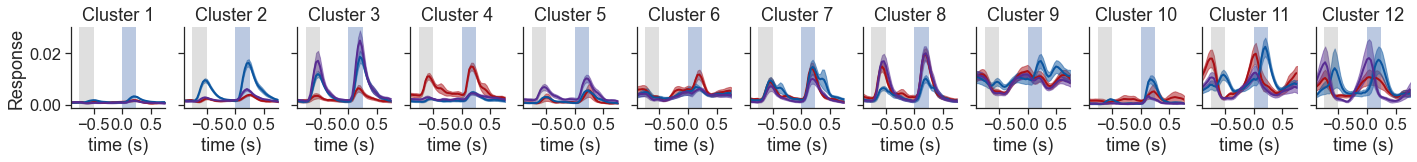

In [60]:
# tmp = change_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
tmp = change_mdf.copy()
tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.8))]

xlim_seconds = [-0.9, 0.75]
timestamps = tmp.trace_timestamps.values[0]

axes_column = 'cluster_id'
hue_column = 'experience_level'

plotting.plot_population_averages_for_clusters(tmp, 'changes', axes_column, hue_column, 
                                            xlim_seconds=xlim_seconds, interval_sec=0.5, 
                                            sharey=True, sharex=False, 
                                            ylabel='response', xlabel='time (s)', suptitle=None,
                                            save_dir=save_dir, folder=folder, suffix='_sharey', ax=None);

In [61]:
# # tmp = change_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
# tmp = change_mdf.copy()
# tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.8))]

# xlim_seconds = [-0.9, 0.75]
# timestamps = tmp.trace_timestamps.values[0]

# axes_column = 'cluster_id'
# hue_column = 'experience_level'

# plotting.plot_population_averages_for_clusters(tmp, 'changes', axes_column, hue_column, 
#                                             xlim_seconds=xlim_seconds, interval_sec=0.5, 
#                                             sharey=False, sharex=False, 
#                                             ylabel='response', xlabel='time (s)', suptitle=None,
#                                             save_dir=save_dir, folder=folder, suffix='_sharey', ax=None);

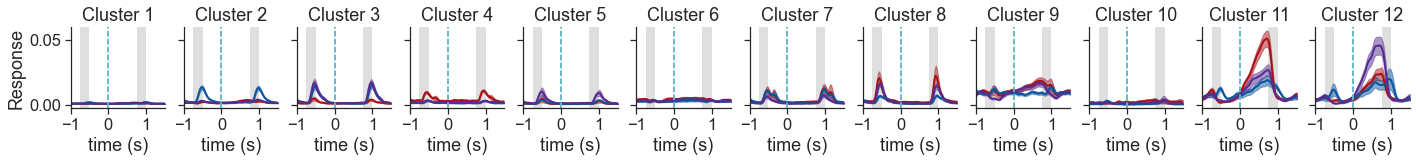

In [62]:
# tmp = omission_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
tmp = omission_mdf.copy()
tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.8))]

xlim_seconds = [-1, 1.5]
timestamps = tmp.trace_timestamps.values[0]

axes_column = 'cluster_id'
hue_column = 'experience_level'

plotting.plot_population_averages_for_clusters(tmp, 'omissions', axes_column, hue_column, 
                                            xlim_seconds=xlim_seconds, interval_sec=1, 
                                            sharey=True, sharex=False, 
                                            ylabel='response', xlabel='time (s)', suptitle=None,
                                            save_dir=save_dir, folder=folder, suffix='_sharey', ax=None);

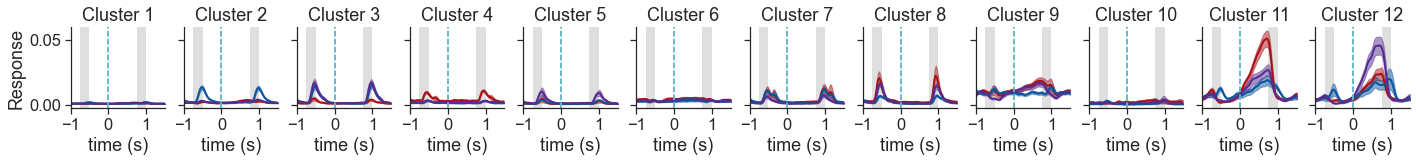

In [63]:
# tmp = omission_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
tmp = omission_mdf.copy()
tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.8))]

xlim_seconds = [-1, 1.5]
timestamps = tmp.trace_timestamps.values[0]

axes_column = 'cluster_id'
hue_column = 'experience_level'

plotting.plot_population_averages_for_clusters(tmp, 'omissions', axes_column, hue_column, 
                                            xlim_seconds=xlim_seconds, interval_sec=1, 
                                            sharey=True, sharex=False, 
                                            ylabel='response', xlabel='time (s)', suptitle=None,
                                            save_dir=save_dir, folder=folder, suffix='_sharey', ax=None);

#### each cre line seprately

In [64]:
# # tmp = image_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
# tmp = image_mdf.copy()
# tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.9))]

# xlim_seconds = [-0.5, 0.7]
# timestamps = tmp.trace_timestamps.values[0]

# plotting.plot_population_averages_for_conditions_multi_row(tmp, data_type, 'all', axes_column='cre_line', hue_column='experience_level', row_column='cluster_id',
#                                             timestamps=None, xlim_seconds=xlim_seconds, interval_sec=0.5, sharey=False, sharex=False, palette=None, 
#                                             ylabel='response', xlabel='time (s)', title=None, suptitle=None,
#                                             save_dir=save_dir, folder=folder, suffix='_images_clusters', ax=None);

no data for 1 Novel +
no data for 2 Novel +
no data for 3 Novel +
no data for 4 Novel +
no data for 5 Novel +
no data for 6 Novel +
no data for 7 Novel +
no data for 8 Novel +
no data for 9 Novel +
no data for 10 Novel +
no data for 11 Novel +
no data for 12 Novel +
no data for 1 Novel +
no data for 2 Novel +
no data for 3 Novel +
no data for 4 Novel +
no data for 5 Novel +
no data for 6 Novel +
no data for 7 Novel +
no data for 8 Novel +
no data for 9 Novel +
no data for 10 Novel +
no data for 11 Novel +
no data for 12 Novel +
no data for 1 Novel +
no data for 2 Novel +
no data for 3 Novel +
no data for 4 Novel +
no data for 5 Novel +
no data for 6 Novel +
no data for 7 Novel +
no data for 8 Novel +
no data for 9 Novel +
no data for 10 Novel +
no data for 11 Novel +
no data for 12 Novel +


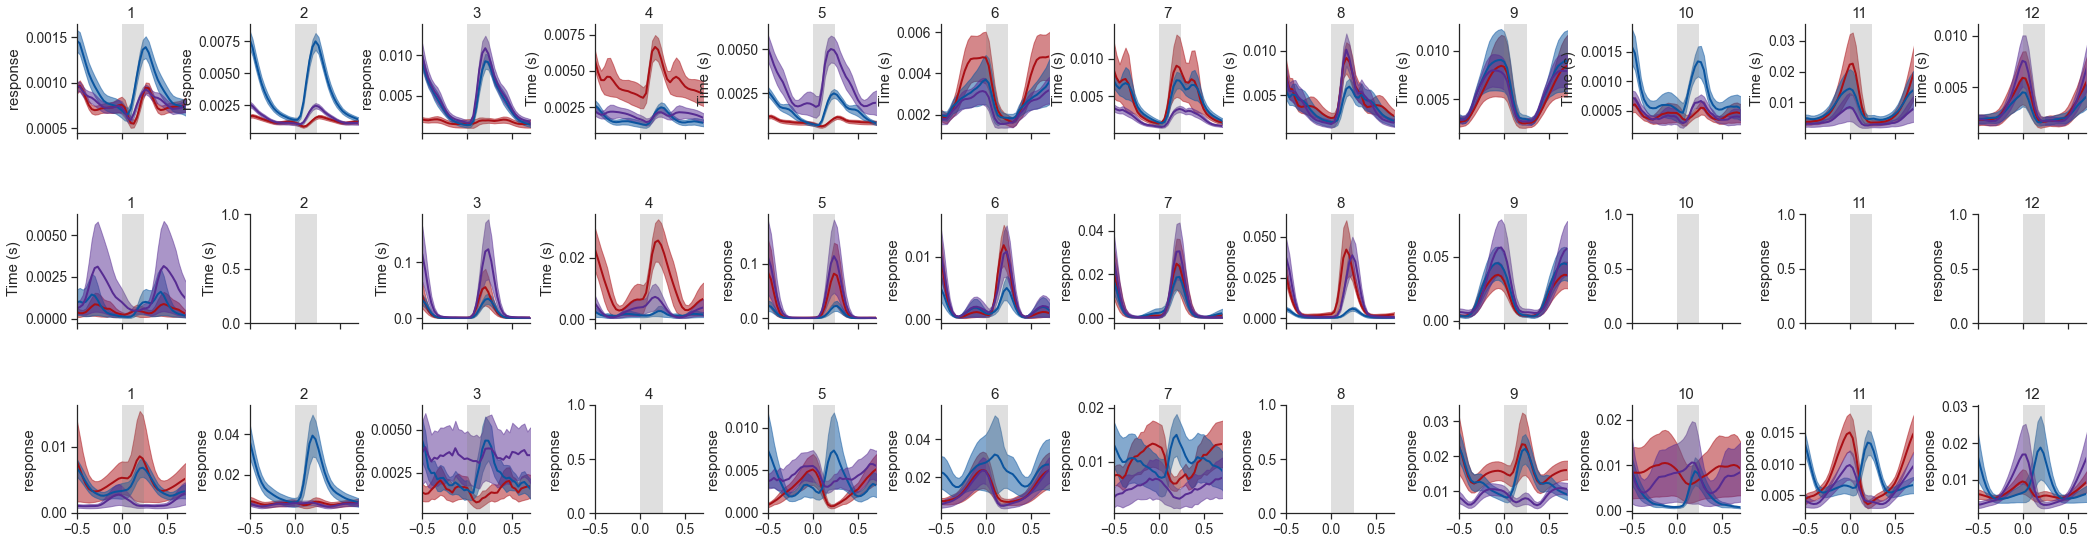

In [65]:
# tmp = image_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
tmp = image_mdf.copy()
tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.9))]

xlim_seconds = [-0.5, 0.7]
timestamps = tmp.trace_timestamps.values[0]

plotting.plot_population_averages_for_conditions_multi_row(tmp, data_type, 'all', 
                                            row_column='cre_line', hue_column='experience_level', axes_column='cluster_id',
                                            timestamps=None, xlim_seconds=xlim_seconds, interval_sec=0.5, sharey=False, sharex=True, palette=None, 
                                            ylabel='response', xlabel='time (s)', title=None, suptitle=None,
                                            save_dir=save_dir, folder=folder, suffix='_images_clusters', ax=None);

no data for 1 Novel +
no data for 2 Novel +
no data for 3 Novel +
no data for 4 Novel +
no data for 5 Novel +
no data for 6 Novel +
no data for 7 Novel +
no data for 8 Novel +
no data for 9 Novel +
no data for 10 Novel +
no data for 11 Novel +
no data for 12 Novel +
no data for 1 Novel +
no data for 2 Novel +
no data for 3 Novel +
no data for 4 Novel +
no data for 5 Novel +
no data for 6 Novel +
no data for 7 Novel +
no data for 8 Novel +
no data for 9 Novel +
no data for 10 Novel +
no data for 11 Novel +
no data for 12 Novel +
no data for 1 Novel +
no data for 2 Novel +
no data for 3 Novel +
no data for 4 Novel +
no data for 5 Novel +
no data for 6 Novel +
no data for 7 Novel +
no data for 8 Novel +
no data for 9 Novel +
no data for 10 Novel +
no data for 11 Novel +
no data for 12 Novel +


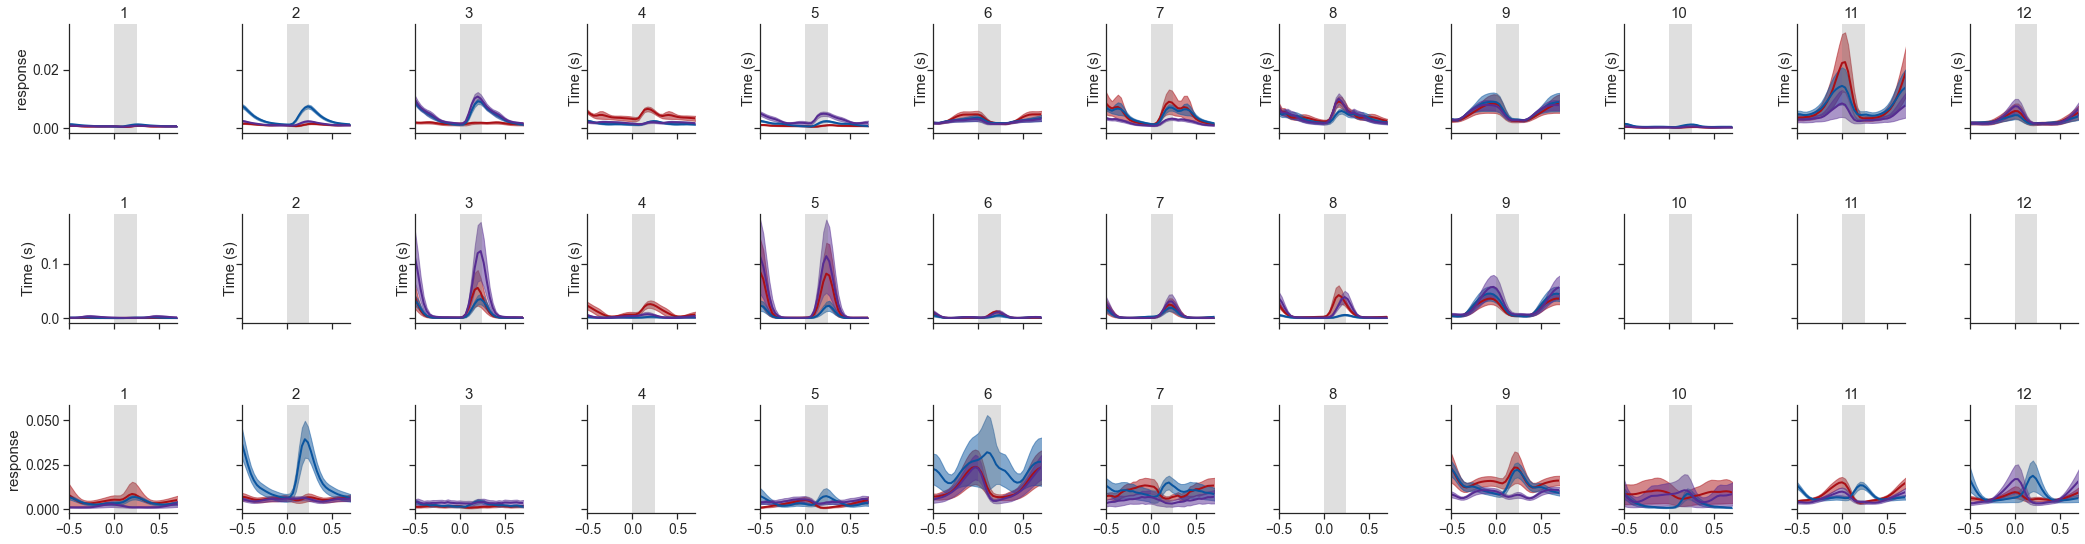

In [66]:
# tmp = image_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
tmp = image_mdf.copy()
tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.9))]

xlim_seconds = [-0.5, 0.7]
timestamps = tmp.trace_timestamps.values[0]

plotting.plot_population_averages_for_conditions_multi_row(tmp, data_type, 'all', 
                                            row_column='cre_line', hue_column='experience_level', axes_column='cluster_id',
                                            timestamps=None, xlim_seconds=xlim_seconds, interval_sec=0.5, sharey='row', sharex=True, palette=None, 
                                            ylabel='response', xlabel='time (s)', title=None, suptitle=None,
                                            save_dir=save_dir, folder=folder, suffix='_images_clusters', ax=None);

In [67]:
# # tmp = change_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
# tmp = change_mdf.copy()
# tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.9))]

# xlim_seconds = [-0.95, 0.7]
# timestamps = tmp.trace_timestamps.values[0]

# plotting.plot_population_averages_for_conditions_multi_row(tmp, data_type, 'changes', axes_column='cre_line', hue_column='experience_level', row_column='cluster_id',
#                                             timestamps=None, xlim_seconds=xlim_seconds, interval_sec=0.5, sharey=False, sharex=False, palette=None, 
#                                             ylabel='response', xlabel='time (s)', title=None, suptitle=None,
#                                             save_dir=save_dir, folder=folder, suffix='_changes_clusters_per_cre', ax=None);

no data for 1 Novel +
no data for 2 Novel +
no data for 3 Novel +
no data for 4 Novel +
no data for 5 Novel +
no data for 6 Novel +
no data for 7 Novel +
no data for 8 Novel +
no data for 9 Novel +
no data for 10 Novel +
no data for 11 Novel +
no data for 12 Novel +
no data for 1 Novel +
no data for 2 Novel +
no data for 3 Novel +
no data for 4 Novel +
no data for 5 Novel +
no data for 6 Novel +
no data for 7 Novel +
no data for 8 Novel +
no data for 9 Novel +
no data for 10 Novel +
no data for 11 Novel +
no data for 12 Novel +
no data for 1 Novel +
no data for 2 Novel +
no data for 3 Novel +
no data for 4 Novel +
no data for 5 Novel +
no data for 6 Novel +
no data for 7 Novel +
no data for 8 Novel +
no data for 9 Novel +
no data for 10 Novel +
no data for 11 Novel +
no data for 12 Novel +


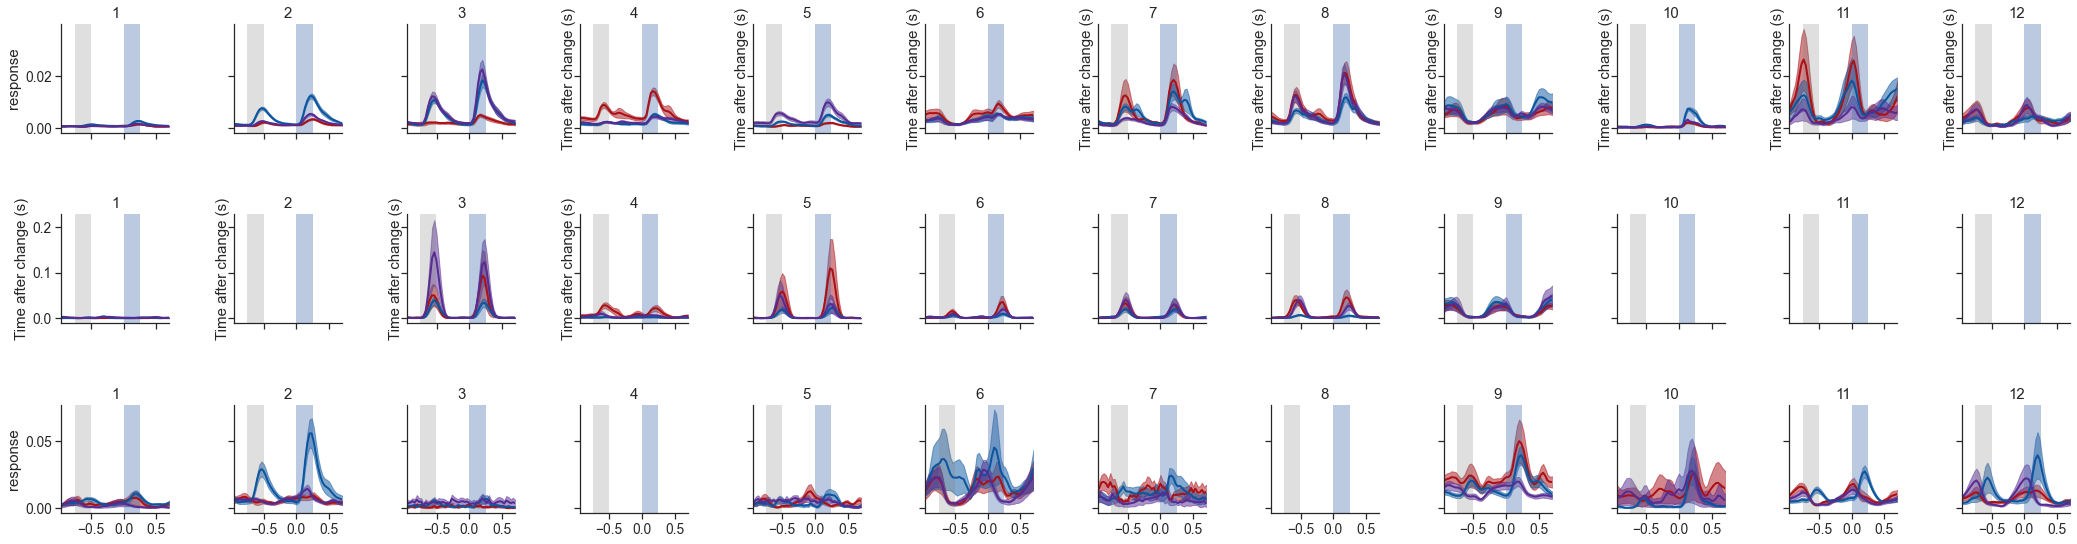

In [68]:
# tmp = change_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
tmp = change_mdf.copy()
tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.9))]

xlim_seconds = [-0.95, 0.7]
timestamps = tmp.trace_timestamps.values[0]

plotting.plot_population_averages_for_conditions_multi_row(tmp, data_type, 'changes', 
                                            row_column='cre_line', hue_column='experience_level', axes_column='cluster_id',
                                            timestamps=None, xlim_seconds=xlim_seconds, interval_sec=0.5, sharey='row', sharex=True, palette=None, 
                                            ylabel='response', xlabel='time (s)', title=None, suptitle=None,
                                            save_dir=save_dir, folder=folder, suffix='_changes_clusters_per_cre', ax=None);

In [69]:
# # tmp = omission_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
# tmp = omission_mdf.copy()
# tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.9))]

# xlim_seconds = [-1, 1.5]
# timestamps = tmp.trace_timestamps.values[0]

# plotting.plot_population_averages_for_conditions_multi_row(tmp, data_type, 'omissions', axes_column='cre_line', hue_column='experience_level', row_column='cluster_id',
#                                             timestamps=None, xlim_seconds=xlim_seconds, interval_sec=0.5, sharey=False, sharex=False, palette=None, 
#                                             ylabel='response', xlabel='time (s)', title=None, suptitle=None,
#                                             save_dir=save_dir, folder=folder, suffix='_omissions_clusters_per_cre', ax=None);

no data for 1 Novel +
no data for 2 Novel +
no data for 3 Novel +
no data for 4 Novel +
no data for 5 Novel +
no data for 6 Novel +
no data for 7 Novel +
no data for 8 Novel +
no data for 9 Novel +
no data for 10 Novel +
no data for 11 Novel +
no data for 12 Novel +
no data for 1 Novel +
no data for 2 Novel +
no data for 3 Novel +
no data for 4 Novel +
no data for 5 Novel +
no data for 6 Novel +
no data for 7 Novel +
no data for 8 Novel +
no data for 9 Novel +
no data for 10 Novel +
no data for 11 Novel +
no data for 12 Novel +
no data for 1 Novel +
no data for 2 Novel +
no data for 3 Novel +
no data for 4 Novel +
no data for 5 Novel +
no data for 6 Novel +
no data for 7 Novel +
no data for 8 Novel +
no data for 9 Novel +
no data for 10 Novel +
no data for 11 Novel +
no data for 12 Novel +


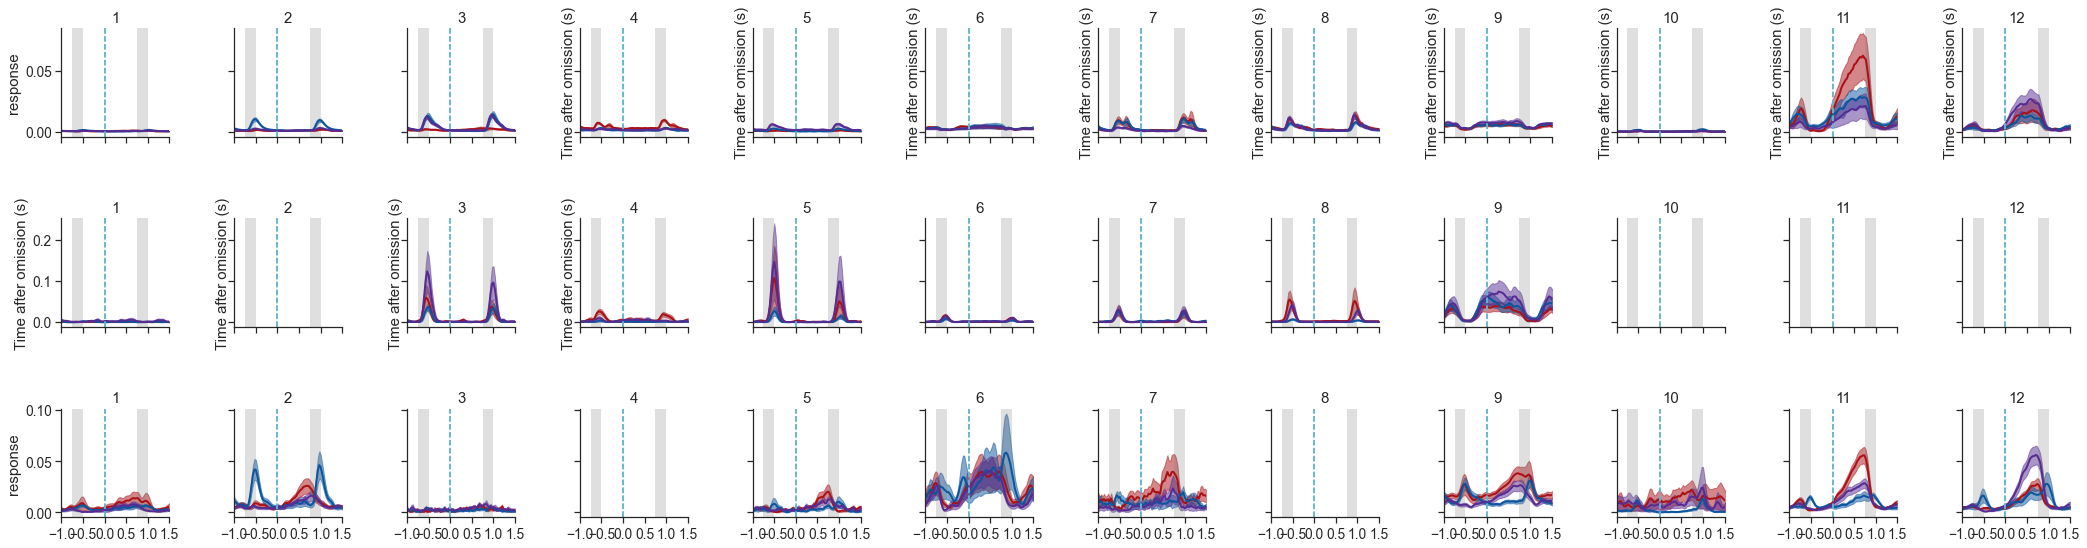

In [70]:
# tmp = omission_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
tmp = omission_mdf.copy()
tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.9))]

xlim_seconds = [-1, 1.5]
timestamps = tmp.trace_timestamps.values[0]

plotting.plot_population_averages_for_conditions_multi_row(tmp, data_type, 'omissions', 
                                            row_column='cre_line', hue_column='experience_level', axes_column='cluster_id',
                                            timestamps=None, xlim_seconds=xlim_seconds, interval_sec=0.5, sharey='row', sharex=True, palette=None, 
                                            ylabel='response', xlabel='time (s)', title=None, suptitle=None,
                                            save_dir=save_dir, folder=folder, suffix='_omissions_clusters_per_cre', ax=None);

#### population averages in a 4x3 grid

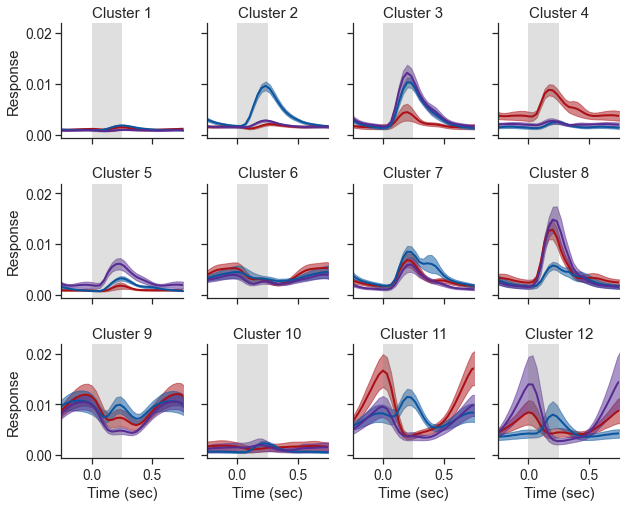

In [71]:
# tmp = image_mdf.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')
tmp = image_mdf.copy()
tmp = tmp[(tmp.mean_baseline<np.percentile(tmp.mean_baseline.values, 99.9)) &  (tmp.mean_response<np.percentile(tmp.mean_response.values, 99.8))]

xlim_seconds = [-0.25, 0.75]
timestamps = tmp.trace_timestamps.values[0]

axes_column = 'cluster_id'
hue_column = 'experience_level'

plotting.plot_population_averages_for_clusters_grid(tmp, event_type, axes_column, hue_column, 
                                            xlim_seconds=xlim_seconds, interval_sec=0.5, 
                                            sharey=True, sharex=True, 
                                            ylabel='response', xlabel='time (s)', suptitle=None,
                                            save_dir=save_dir, folder=folder, suffix='_sharey', ax=None);

#### heatmap of image responses per cluster 

In [72]:
# tmp = image_mdf.copy() #merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

# xlim_seconds=[-0.5, 0.75]

# event_type = 'all'

# timestamps = tmp.trace_timestamps.values[0]
# row_condition = 'experience_level'
# col_condition = 'cluster_id'
# cols_to_sort_by = ['mean_response']

# for cre_line in tmp.cre_line.unique():
#     df = tmp[tmp.cre_line==cre_line]


#     ppf.plot_response_heatmaps_for_conditions(df, timestamps, data_type, 'all',
#                                           row_condition, col_condition, cols_to_sort_by=cols_to_sort_by, suptitle=cre_line,
#                                           microscope=None, vmax=None, xlim_seconds=xlim_seconds, match_cells=False, cbar=False,
#                                           save_dir=None, folder=folder, suffix='', ax=None)


#### heatmap of omission responses per clsuter

In [73]:
# tmp = omission_mdf.copy() #merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

# xlim_seconds=[-1, 1.5]

# event_type = 'all'

# timestamps = tmp.trace_timestamps.values[0]
# row_condition = 'experience_level'
# col_condition = 'cluster_id'
# cols_to_sort_by = ['mean_response']

# for cre_line in tmp.cre_line.unique():
#     df = tmp[tmp.cre_line==cre_line]


#     ppf.plot_response_heatmaps_for_conditions(df, timestamps, data_type, 'omissions',
#                                           row_condition, col_condition, cols_to_sort_by=cols_to_sort_by, suptitle=cre_line,
#                                           microscope=None, vmax=None, xlim_seconds=xlim_seconds, match_cells=False, cbar=False,
#                                           save_dir=None, folder=folder, suffix='', ax=None)


### compare various functions for area depth proportions

In [74]:
import visual_behavior_glm.GLM_clustering as glm_clust

In [75]:
locations = np.sort(cluster_meta.layer.unique())
df = cluster_meta.copy().reset_index()
df['location'] = df.layer

stats_table = glm_clust.stats(df, cre_lines[0], locations, test='chi_squared_')
stats_table.head()

location,lower,upper,lower_chance_count,upper_chance_count,chi_squared_pvalue,significant,imq,bh_significant
cluster_id,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,243.0,479.0,407.848999,314.151001,3.580637e-35,True,0.004167,True
2,309.0,302.0,345.146452,265.853548,3.181840e-03,True,0.029167,True
3,206.0,171.0,212.962705,164.037295,4.694883e-01,False,0.041667,False
4,223.0,90.0,176.809885,136.190115,1.392968e-07,True,0.012500,True


In [76]:
# this gets the number of cells in different locations compared to the total
n_cells = processing.get_n_cells_per_location_for_clusters(cluster_meta, location='layer')
n_cells.head()

n_cells_lower  n_cells_upper  n_cells_cluster  \
cre_line          cluster_id                                                  
Slc17a7-IRES2-Cre 1                   243.0          479.0              722   
                  2                   309.0          302.0              611   
                  3                   206.0          171.0              377   
                  4                   223.0           90.0              313   
                  5                   178.0          132.0              310   

                              n_cells_total_lower  n_cells_total_upper  
cre_line          cluster_id                                            
Slc17a7-IRES2-Cre 1                          1863                 1435  
                  2                          1863                 1435  
                  3                          1863                 1435  
                  4                          1863                 1435  
                  5                          1863                 1435

In [77]:
# this gets the fraction of cells in different locations relative to the total
fraction_cells = processing.get_fraction_cells_relative_to_cluster_size(cluster_meta, location='layer')
fraction_cells.head()

fraction_cells_lower  fraction_cells_upper  \
cre_line          cluster_id                                               
Slc17a7-IRES2-Cre 1                       0.130435              0.333798   
                  2                       0.165862              0.210453   
                  3                       0.110574              0.119164   
                  4                       0.119699              0.062718   
                  5                       0.095545              0.091986   

                              fraction_cells_cluster  average_of_locations  \
cre_line          cluster_id                                                 
Slc17a7-IRES2-Cre 1                         0.218921              0.232116   
                  2                         0.185264              0.188157   
                  3                         0.114312              0.114869   
                  4                         0.094906              0.091209   
                  5                         0.093996              0.093765   

                              fraction_of_cluster_size_lower  \
cre_line          cluster_id                                   
Slc17a7-IRES2-Cre 1                                 0.595809   
                  2                                 0.895272   
                  3                                 0.967306   
                  4                                 1.261242   
                  5                                 1.016474   

                              fraction_of_cluster_size_upper  
cre_line          cluster_id                                  
Slc17a7-IRES2-Cre 1                                 1.524744  
                  2                                 1.135964  
                  3                                 1.042446  
                  4                                 0.660841  
                  5                                 0.978613

In [78]:
# this gets all the stats, including n cells, fraction cells, and significance across location comparisons
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location='layer')

n_cells_table.head()

n_cells_location  n_cells_location_total  \
cre_line          cluster_id layer                                             
Slc17a7-IRES2-Cre 1          lower               243                    1863   
                             upper               479                    1435   
                  2          lower               309                    1863   
                             upper               302                    1435   
                  3          lower               206                    1863   

                                    fraction_cells_location  n_cells_cluster  \
cre_line          cluster_id layer                                             
Slc17a7-IRES2-Cre 1          lower                 0.130435              722   
                             upper                 0.333798              722   
                  2          lower                 0.165862              611   
                             upper                 0.210453              611   
                  3          lower                 0.110574              377   

                                    n_cells_cre  fraction_cells_cluster  \
cre_line          cluster_id layer                                        
Slc17a7-IRES2-Cre 1          lower         3298                0.218921   
                             upper         3298                0.218921   
                  2          lower         3298                0.185264   
                             upper         3298                0.185264   
                  3          lower         3298                0.114312   

                                    fraction_of_cluster_size  \
cre_line          cluster_id layer                             
Slc17a7-IRES2-Cre 1          lower                  0.595809   
                             upper                  1.524744   
                  2          lower                  0.895272   
                             upper                  1.135964   
                  3          lower                  0.967306   

                                    n_cells_chance_location        pvalue  \
cre_line          cluster_id layer                                          
Slc17a7-IRES2-Cre 1          lower               407.848999  3.580637e-35   
                             upper               314.151001  3.580637e-35   
                  2          lower               345.146452  3.181840e-03   
                             upper               265.853548  3.181840e-03   
                  3          lower               212.962705  4.694883e-01   

                                   significant       imq bh_significant  
cre_line          cluster_id layer                                       
Slc17a7-IRES2-Cre 1          lower        True  0.000000           True  
                             upper        True  0.000000           True  
                  2          lower        True  0.008333           True  
                             upper        True  0.008333           True  
                  3          lower       False  0.016667          False

In [79]:
# compare with Alex's code numbers

locations = np.sort(cluster_meta.layer.unique())
df = cluster_meta.copy().reset_index()
df['location'] = df.layer

stats_table = glm_clust.stats(df, cre_lines[0], locations, test='chi_squared_')
stats_table.head()

location,lower,upper,lower_chance_count,upper_chance_count,chi_squared_pvalue,significant,imq,bh_significant
cluster_id,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,243.0,479.0,407.848999,314.151001,3.580637e-35,True,0.004167,True
2,309.0,302.0,345.146452,265.853548,3.181840e-03,True,0.029167,True
3,206.0,171.0,212.962705,164.037295,4.694883e-01,False,0.041667,False
4,223.0,90.0,176.809885,136.190115,1.392968e-07,True,0.012500,True


conclusion: `processing.get_cluster_proportion_stats_for_locations()` provides the same results as `glm_clust.stats()`, but in an easier to parse format with additional information that is helpful for plotting

### area / depth distributions across clusters

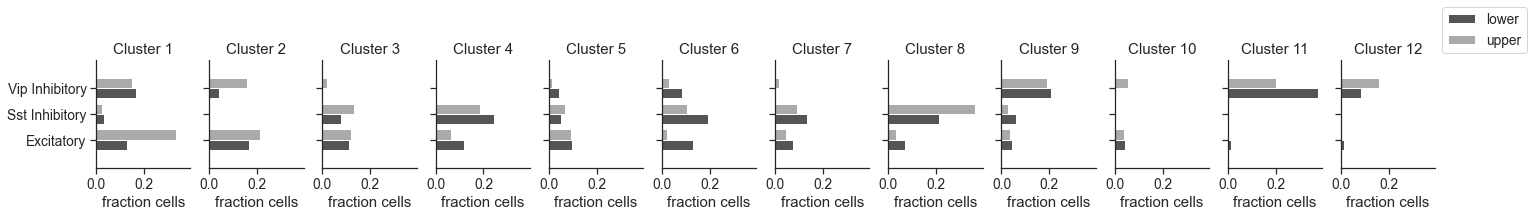

In [80]:
location = 'layer'
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)
x = 'fraction_cells_location'

data = n_cells_table.copy().reset_index()

cre_lines = np.sort(cluster_meta.cre_line.unique())
cell_types = [utils.convert_cre_line_to_cell_type(cre_line) for cre_line in cre_lines]
cluster_ids = np.sort(cluster_meta.cluster_id.unique())

axes_conditions = np.sort(cluster_meta['cluster_id'].unique())
hue_conditions = np.sort(cluster_meta[location].unique())
n_axes_conditions = len(axes_conditions)

sharey = True 

if sharey == True: 
    wspace = 0.2
    fig_width = 2
else:
    wspace = 0.5
    fig_width = 3.5
    
figsize = (fig_width * n_axes_conditions, 2)
fig, ax = plt.subplots(1, n_axes_conditions, figsize=figsize, sharey=sharey, sharex=True)
ax = ax.ravel()
for i, cluster_id in enumerate(cluster_ids):
    cluster_data = data[data.cluster_id==cluster_id]
    # order = cre_data.sort_values(by='fraction_per_cluster')['cluster_id'][::-1]
    ax[i] = sns.barplot(data=cluster_data, x='fraction_cells_location', y='cre_line', order=cre_lines,
                            hue=location, orient='h', palette='gray', width=0.8, ax=ax[i])
    ax[i].set_ylabel('')
    ax[i].set_xlabel('fraction cells')
    ax[i].set_title('Cluster '+str(cluster_id))
    ax[i].get_legend().remove()
    ax[i].set_ylim(-1.1, len(cre_lines)+0.1)
ax[0].set_yticklabels(cell_types)
ax[i].legend( bbox_to_anchor=(1,1))
# ax[1].set_ylabel('fraction cells in each cluster')
# ax[i].set_xlabel('cluster ID')
sns.despine(fig=fig, top=True, right=True, left=False, bottom=False, offset=None, trim=False)

suptitle = ''
if suptitle is not None:
    plt.suptitle(suptitle, x=0.52, y=1.04, fontsize=18)
fig.subplots_adjust(wspace=wspace, hspace=0.75)
if save_dir:
    fig_title = 'fraction_cells_' + location + '_' + x + '_horiz'
    utils.save_figure(fig, figsize, save_dir, folder, fig_title)

#### by layer

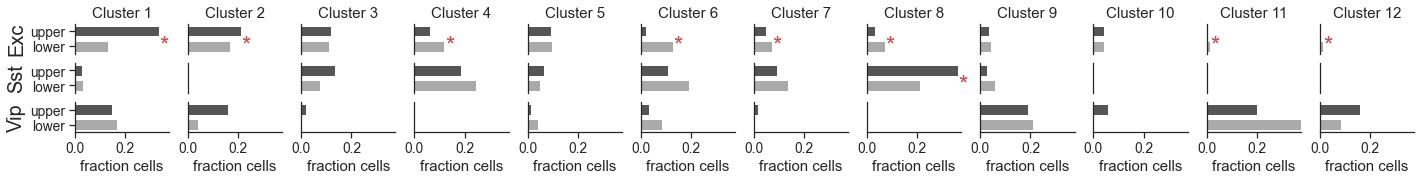

In [81]:
location = 'layer'
order = ['upper', 'lower']
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

metric = 'fraction_cells_location'
xlabel = 'fraction cells'
significance_col = 'bh_significant'

plotting.plot_location_distribution_across_clusters_for_cre_lines(n_cells_table, location=location, order=order,
                                                             metric=metric, xlabel=xlabel,
                                                             significance_col=significance_col,
                                                             ax=None, save_dir=save_dir, folder=folder);

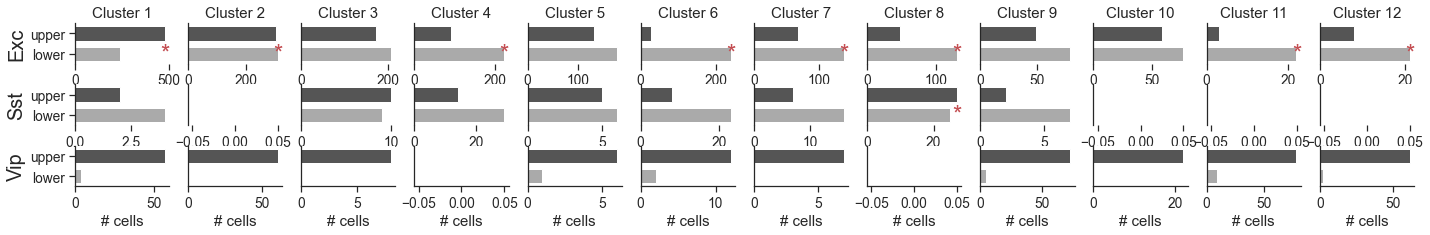

In [82]:
location = 'layer'
order = ['upper', 'lower']
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

metric = 'n_cells_location'
xlabel = '# cells'
significance_col = 'bh_significant'

plotting.plot_location_distribution_across_clusters_for_cre_lines(n_cells_table, location=location, order=order,
                                                             metric=metric, xlabel=xlabel,
                                                             significance_col=significance_col, sharex=False,
                                                             ax=None, save_dir=save_dir, folder=folder);

In [83]:
location = 'binned_depth'
# order = ['upper', 'lower']
n_cells_table_depth = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

metric = 'fraction_cells_location'
xlabel = 'fraction cells'
significance_col = 'bh_significant'

plotting.plot_location_distribution_across_clusters_for_cre_lines(n_cells_table_depth, location=location, order=None,
                                                             metric=metric, xlabel=xlabel,
                                                             significance_col=significance_col,
                                                             ax=None, save_dir=save_dir, folder=folder);

ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:
0.03939489442168282

In [ ]:
location = 'binned_depth'
# order = ['upper', 'lower']
n_cells_table_depth = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

metric = 'n_cells_location'
xlabel = '# cells'
significance_col = 'bh_significant'

plotting.plot_location_distribution_across_clusters_for_cre_lines(n_cells_table_depth, location=location, order=None,
                                                             metric=metric, xlabel=xlabel,
                                                             significance_col=significance_col,
                                                             sharex=False, 
                                                             ax=None, save_dir=save_dir, folder=folder);

#### by area

In [ ]:
location = 'targeted_structure'
order = ['VISp', 'VISl']
n_cells_table_depth = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

metric = 'fraction_cells_location'
xlabel = 'fraction cells'
significance_col = 'bh_significant'

plotting.plot_location_distribution_across_clusters_for_cre_lines(n_cells_table_depth, location=location, order=order,
                                                             metric=metric, xlabel=xlabel,
                                                             significance_col=significance_col,
                                                             sharex=True, 
                                                             ax=None, save_dir=save_dir, folder=folder);

In [ ]:
location = 'targeted_structure'
order = ['VISp', 'VISl']
n_cells_table_depth = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

metric = 'n_cells_location'
xlabel = '# cells'
significance_col = 'bh_significant'

plotting.plot_location_distribution_across_clusters_for_cre_lines(n_cells_table_depth, location=location, order=order,
                                                             metric=metric, xlabel=xlabel,
                                                             significance_col=significance_col,
                                                             sharex=False, 
                                                             ax=None, save_dir=save_dir, folder=folder);

In [ ]:
stats_table = glm_clust.stats(df, cre_lines[0], locations, test='chi_squared_')
stats_table.head()

In [ ]:
# cluster proportions for all cre lines
# this code uses glm_clust.final() to count how many cells per location per cluster per cre, 
# divide it by the total number of cells in each location in each cre
# then subtracts the average proportion across locations for each cluster
# does this make sense??
proportions, stats_final = processing.get_proportion_cells_rel_cluster_average(cluster_meta, cre_lines,
                                                                         columns_to_groupby=['layer'])
proportions.head()

In [ ]:
stats = processing.compute_cluster_proportion_stats(cluster_meta.reset_index(), cre_lines[0], location='layer')
stats

In [ ]:
# # computing stats on proportions directly rather than counts - probably wrong

# from scipy.stats import chisquare

# location = 'layer'
# locations = np.sort(cluster_meta[location].unique())
# fraction_per_location_cols = []
# for loc in locations: 
#     fraction_per_location_cols.append('fraction_cells_'+loc)

# # # compute estimated frequency of cells based on average fraction for each cluster
# # for loc in locations:
# #     fraction_cells[loc + '_chance_count'] = fraction_cells['fraction_cells_'+loc].sum() * fraction_cells['mean']
    
# # perform chi-squared test
# for index in fraction_cells.index.values:
#     f = fraction_cells.loc[index][fraction_per_location_cols].values
#     # chance is just the overall size of the cluster
#     f_expected = np.repeat(fraction_cells.loc[index]['fraction_cells_per_cluster'], len(locations))
#     out = chisquare(f, f_expected)
#     fraction_cells.at[index, 'pvalue'] = out.pvalue
#     fraction_cells.at[index, 'significant'] = out.pvalue < 0.05

# # Use Benjamini Hochberg Correction for multiple comparisons
# fraction_cells = processing.add_hochberg_correction(fraction_cells)

# fraction_cells.head()

In [ ]:
# cluster proportions for all cre lines
proportions, stats = processing.get_proportion_cells_rel_cluster_average(cluster_meta, cre_lines,
                                                                         columns_to_groupby=['layer'])

In [ ]:
proportions.head()

### cluster metrics vs. area depth proportion

#### get metrics

In [ ]:
# cluster_metrics_all_cre = processing.get_cluster_metrics_all_cre(cluster_meta, feature_matrix, results_pivoted)
# cluster_metrics_all_cre.head()

#### link cluster metrics to area depth

In [ ]:
# # cell metrics
# coding_score_metrics = processing.get_cell_metrics(cluster_meta, results_pivoted)
# # for each cre
# cluster_metrics = processing.get_cluster_metrics(cluster_meta, feature_matrix, results_pivoted)

# location = 'layer'
# order = ['upper', 'lower']
# n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

# cluster_metrics = processing.add_layer_index_to_cluster_metrics(cluster_metrics, n_cells_table)

# # make the plot 

# x = 'exp_mod_direction' # novel-familiar / sum
# y = 'layer_index' # upper-lower / sum
# hue = 'cell_type'

# if 'cell_type' not in cluster_metrics.columns:
#     # cluster_metrics['cre_line'] = cluster_metrics.index.get_level_values(0)
#     cluster_metrics['cell_type'] = [utils.convert_cre_line_to_cell_type(cre_line) for cre_line in cluster_metrics.index.get_level_values(0)]

# plotting.plot_cluster_metric_comparison_scatterplot(cluster_metrics, cluster_meta, x=x, y=y, hue=hue, save_dir=save_dir, folder=folder)


In [ ]:
# x = 'exp_mod_direction' # novel-familiar / sum
# y = 'layer_index' # upper-lower / sum
# hue = 'cell_type'

# if 'cell_type' not in cluster_metrics.columns:
#     # cluster_metrics['cre_line'] = cluster_metrics.index.get_level_values(0)
#     cluster_metrics['cell_type'] = [utils.convert_cre_line_to_cell_type(cre_line) for cre_line in cluster_metrics.index.get_level_values(0)]

# plotting.plot_cluster_metric_comparison_scatterplot(cluster_metrics, cluster_meta, x=x, y=y, hue=hue, save_dir=save_dir, folder=folder)


### split by cre line and plot heatmaps

c:\users\iryna.yavorska\documents\github\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_meta_cre.cluster_id.values]


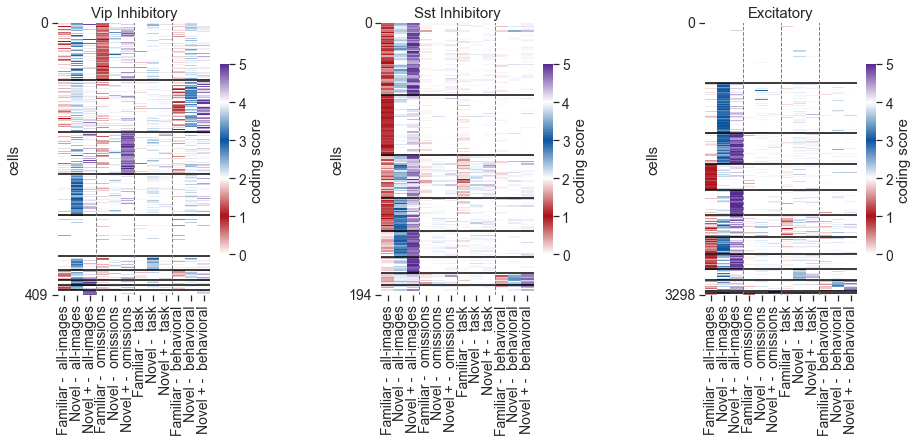

In [84]:
# plot feature matrix sorted by cluster ID
feature_matrix_remapped, remapped_cmap, vmax = plotting.remap_coding_scores_to_session_colors(feature_matrix)

plotting.plot_feature_matrix_sorted(feature_matrix_remapped, cluster_meta, sort_col='cluster_id', resort_by_size=True,
                                    cmap=remapped_cmap, vmax=vmax, save_dir=None, folder=folder)

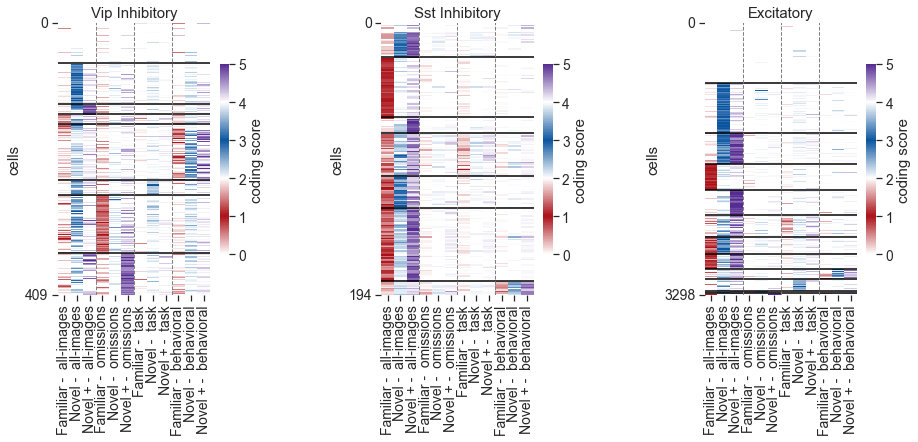

In [85]:
# plot feature matrix sorted by cluster ID
# plot feature matrix sorted by cluster ID
feature_matrix_remapped, remapped_cmap, vmax = plotting.remap_coding_scores_to_session_colors(feature_matrix)

plotting.plot_feature_matrix_sorted(feature_matrix_remapped, cluster_meta, sort_col='cluster_id', resort_by_size=False,
                                    cmap=remapped_cmap, vmax=vmax, save_dir=None, folder=folder)

### average dropouts per cluster - updated colors

In [ ]:
# plot clusters in order of sort_col
clusters = np.sort(cluster_meta['cluster_id'].unique())
n_clusters_to_plot = len(clusters)


feature_matrix_remapped, remapped_cmap, vmax = plotting.remap_coding_scores_to_session_colors(feature_matrix)


figsize = (35, 1.7)
fig, ax = plt.subplots(1, n_clusters_to_plot, figsize=figsize, sharex=True, sharey=True)
ax = ax.ravel()

  
# loop through clusters in sorted order
for i, cluster_id in enumerate(clusters):
    this_cluster_csids = cluster_meta[cluster_meta.cluster_id==cluster_id].index.values
    mean_dropout_df = feature_matrix_remapped.loc[this_cluster_csids].mean().unstack()
    ax[i] = sns.heatmap(mean_dropout_df, cmap=remapped_cmap, vmin=0, vmax=vmax, ax=ax[i], cbar=False, cbar_kws={'label': 'coding score'})
    # fraction is number of cells in this cluster vs all cells in this cre line
    fraction_cluster = len(this_cluster_csids) / float(len(cluster_meta))
    fraction = np.round(fraction_cluster * 100, 1)
    # set title and labels
    ax[i].set_title('cluster ' + str(cluster_id) + '\n' + str(fraction) + '%, n=' + str(len(this_cluster_csids)))
    ax[i].set_xlabel('')
    
plt.subplots_adjust(hspace=0.6, wspace=0.25)
if save_dir:
    utils.save_figure(fig, figsize, save_dir, folder,
                      'mean_cluster_heatmaps_remapped_'+str(n_clusters))

#### averages per cre line 

In [ ]:
# all cre lines on one plot

feature_matrix_remapped, remapped_cmap, vmax = plotting.remap_coding_scores_to_session_colors(feature_matrix)

clusters = np.sort(cluster_meta['cluster_id'].unique())
n_clusters = len(clusters)

figsize = (2.5*n_clusters, 2.5*3)
fig, ax = plt.subplots(3, n_clusters, figsize=figsize, sharex=True, sharey=True)
ax = ax.ravel()

i=0
for c, cre_line in enumerate(np.sort(cluster_meta.cre_line.unique())):
    cre_cluster_meta = cluster_meta[cluster_meta.cre_line==cre_line].copy()

    # loop through clusters in sorted order
    for x, cluster_id in enumerate(clusters):
        try:
            this_cluster_csids = cre_cluster_meta[cre_cluster_meta.cluster_id==cluster_id].index.values
            mean_dropout_df = feature_matrix_remapped.loc[this_cluster_csids].mean().unstack()
            ax[i] = sns.heatmap(mean_dropout_df, cmap=remapped_cmap, vmin=0, vmax=vmax, ax=ax[i], cbar=False, cbar_kws={'label': 'coding score'})
            # fraction is number of cells in this cluster vs all cells in this cre line
            fraction_cluster = len(this_cluster_csids) / float(len(cre_cluster_meta))
            fraction = np.round(fraction_cluster * 100, 1)
            # set title and labels
            ax[i].set_title('cluster ' + str(cluster_id) + '\n' + str(fraction) + '%, n=' + str(len(this_cluster_csids)))
            ax[i].set_xlabel('')
        except:
            pass
        i+=1
        
    plt.subplots_adjust(hspace=0.6, wspace=0.25)
    # plt.suptitle(cre_line, x=0.46, y=1.)
    if save_dir:
        utils.save_figure(fig, figsize, save_dir, folder,
                      'mean_cluster_heatmaps_remapped')

In [ ]:
# plot and sort each cre line separately

feature_matrix_remapped, remapped_cmap, vmax = plotting.remap_coding_scores_to_session_colors(feature_matrix)


for cre_line in cluster_meta.cre_line.unique():
    cre_cluster_meta = cluster_meta[cluster_meta.cre_line==cre_line].copy()
    # clusters = np.sort(cre_cluster_meta['cluster_id'].unique())
    # sort by cluster size
    clusters = cre_cluster_meta['cluster_id'].value_counts().index.values
    n_clusters_to_plot = len(clusters)

    figsize = (2.5*n_clusters_to_plot, 1.7)
    fig, ax = plt.subplots(1, n_clusters_to_plot, figsize=figsize, sharex=True, sharey=True)
    ax = ax.ravel()

    
    # loop through clusters in sorted order
    for i, cluster_id in enumerate(clusters):
        this_cluster_csids = cre_cluster_meta[cre_cluster_meta.cluster_id==cluster_id].index.values
        mean_dropout_df = feature_matrix_remapped.loc[this_cluster_csids].mean().unstack()
        ax[i] = sns.heatmap(mean_dropout_df, cmap=remapped_cmap, vmin=0, vmax=vmax, ax=ax[i], cbar=False, cbar_kws={'label': 'coding score'})
        # fraction is number of cells in this cluster vs all cells in this cre line
        fraction_cluster = len(this_cluster_csids) / float(len(cre_cluster_meta))
        fraction = np.round(fraction_cluster * 100, 1)
        # set title and labels
        ax[i].set_title('cluster ' + str(cluster_id) + '\n' + str(fraction) + '%, n=' + str(len(this_cluster_csids)))
        ax[i].set_xlabel('')
        
    plt.subplots_adjust(hspace=0.6, wspace=0.25)
    plt.suptitle(cre_line, x=0.46, y=1.5)
    if save_dir:
        utils.save_figure(fig, figsize, save_dir, folder,
                      'mean_cluster_heatmaps_remapped_'+cre_line.split('-')[0])

#### sort by cluster size within cre, exclude clusters with <10% cells

In [ ]:
cluster_metrics_per_cre = processing.get_cluster_metrics(cluster_meta, feature_matrix, results_pivoted)
cluster_metrics_per_cre = cluster_metrics_per_cre.reset_index()
# cluster_metrics_per_cre = cluster_metrics_per_cre[(cluster_metrics_per_cre.cre_line==cre_line)&(cluster_metrics_per_cre.n_cells_cluster>10)]
cluster_metrics_per_cre.head()

In [ ]:
# plot clusters in order of sort_col

feature_matrix_remapped, remapped_cmap, vmax = plotting.remap_coding_scores_to_session_colors(feature_matrix)


for cre_line in cluster_meta.cre_line.unique():
    cre_cluster_meta = cluster_meta[cluster_meta.cre_line==cre_line].copy()

    clusters_to_include = cluster_metrics_per_cre[(cluster_metrics_per_cre.cre_line==cre_line)&(cluster_metrics_per_cre.n_cells_cluster>10)].cluster_id.unique()
    clusters = cre_cluster_meta[cre_cluster_meta.cluster_id.isin(clusters_to_include)]['cluster_id'].value_counts().index.values    
    n_clusters_to_plot = len(clusters)

    figsize = (2.5*n_clusters_to_plot, 1.7)
    fig, ax = plt.subplots(1, n_clusters_to_plot, figsize=figsize, sharex=True, sharey=True)
    ax = ax.ravel()

    
    # loop through clusters in sorted order
    for i, cluster_id in enumerate(clusters):
        this_cluster_csids = cre_cluster_meta[cre_cluster_meta.cluster_id==cluster_id].index.values
        mean_dropout_df = feature_matrix_remapped.loc[this_cluster_csids].mean().unstack()
        ax[i] = sns.heatmap(mean_dropout_df, cmap=remapped_cmap, vmin=0, vmax=vmax, ax=ax[i], cbar=False, cbar_kws={'label': 'coding score'})
        # fraction is number of cells in this cluster vs all cells in this cre line
        fraction_cluster = len(this_cluster_csids) / float(len(cre_cluster_meta))
        fraction = np.round(fraction_cluster * 100, 1)
        # set title and labels
        ax[i].set_title('cluster ' + str(cluster_id) + '\n' + str(fraction) + '%, n=' + str(len(this_cluster_csids)))
        ax[i].set_xlabel('')
        
    plt.subplots_adjust(hspace=0.6, wspace=0.25)
    plt.suptitle(cre_line, x=0.46, y=1.5)
    if save_dir:
        utils.save_figure(fig, figsize, save_dir, folder,
                      'mean_cluster_heatmaps_remapped_sorted_'+cre_line.split('-')[0])

## graphical abstract figure 

Goal: make figure representing the major clusters for each cre line, with each cluster represented as one point (cell) using the color for experience modulation, shape for cre line, y position for type and strength of coding, x position for area-depth bias

* Use pref exp level (or index) for color of fill
* Pref feature for x position (strength of coding for each as order)
* Get upper v. lower for significant diffs, set as y position; nonsig in middle
* Cre lines as shapes
* Only include clusters with >5% cells

#### get data

In [ ]:
# for each cre
cluster_metrics = processing.get_cluster_metrics(cluster_meta, feature_matrix, results_pivoted)
cluster_metrics.head()

In [ ]:
location = 'layer'
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)
n_cells_table.head()

In [ ]:
layer_index = n_cells_table[['fraction_cells_location']].unstack()
layer_index.columns = layer_index.columns.droplevel(0)
layer_index['layer_index'] = (layer_index.upper-layer_index.lower)/(layer_index.upper+layer_index.lower)
layer_index = layer_index.merge(n_cells_table[['bh_significant', 'significant']], on=['cre_line', 'cluster_id'])
layer_index = layer_index.reset_index().drop_duplicates(subset=['cre_line', 'cluster_id']).set_index(['cre_line', 'cluster_id'])
layer_index.head()

#### seaborn plot

In [ ]:
# get data to plot
df = cluster_metrics.merge(layer_index, on=['cre_line', 'cluster_id']).sort_values(by='max_coding_score')
df = df[df.fraction_cre>0.07]

# color by experience mod index, which ranges from -1, 1 
# can round values to 0.1 to index into cmap binned into 20 colors
colors = sns.color_palette('RdBu', 20)
value_order = np.arange(-1, 1, 0.1)
value_order = [np.round(value, 1) for value in value_order]
# markers for cre lines 
marker_dict = {'Slc17a7-IRES2-Cre': '^', 
                'Sst-IRES-Cre': 'o', 
                'Vip-IRES-Cre': 'd'}

# make plot
figsize = (6,4)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.scatterplot(data=df.reset_index(), x='max_image_coding_score', y='layer_index', 
                hue='exp_mod_direction', palette='RdBu', size='fraction_cre', sizes=(1,500),
                markers=marker_dict, style='cre_line', edgecolor='gray', ax=ax)
ax.legend(bbox_to_anchor=(1,1), fontsize='x-small', title_fontsize='x-small')
# ax.hlines(y=0, xmin=0, xmax=1, linestyle='--', color='gray', linewidth=1)
ax.set_title('Size, location, coding strength,\n and experience dependence for major clusters')
ax.set_ylabel('layer bias\n<- lower --- upper ->')
ax.set_xlabel('image coding strength ->')
ax.set_ylim(-0.8, 0.8)
sns.despine(left=True, bottom=True)
for index in df.index.values:  
    cluster_id = index[1]
    x_pos = df.loc[index, 'max_image_coding_score']
    y_pos = df.loc[index, 'layer_index']
    size = df.loc[index, 'fraction_cre']
    ax.text(x=x_pos+size*0.1, y=y_pos+size*0.1, s=str(cluster_id), fontsize=12, color='k', ha='left', va='bottom')

In [ ]:
# get data to plot
df = cluster_metrics.merge(layer_index, on=['cre_line', 'cluster_id']).sort_values(by='max_coding_score')
df = df[df.fraction_cre>0.04]

# color by experience mod index, which ranges from -1, 1 
# can round values to 0.1 to index into cmap binned into 20 colors
colors = sns.color_palette('RdBu', 20)
value_order = np.arange(-1, 1, 0.1)
value_order = [np.round(value, 1) for value in value_order]
# markers for cre lines 
marker_dict = {'Slc17a7-IRES2-Cre': '^', 
                'Sst-IRES-Cre': 'o', 
                'Vip-IRES-Cre': 'd'}

# make plot
figsize = (6,4)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.scatterplot(data=df.reset_index(), x='max_image_coding_score', y='layer_index', 
                hue='exp_mod_direction', palette='RdBu', size='fraction_cre', sizes=(1,500),
                markers=marker_dict, style='cre_line', ax=ax)
ax.legend(bbox_to_anchor=(1,1), fontsize='x-small', title_fontsize='x-small')
# ax.hlines(y=0, xmin=0, xmax=1, linestyle='--', color='gray', linewidth=1)
ax.set_title('Size, location, coding strength,\n and experience dependence across clusters')
ax.set_ylabel('layer bias\n<- lower --- upper ->')
ax.set_xlabel('image coding strength ->')
ax.set_ylim(-0.8, 0.8)
sns.despine(left=True, bottom=True)
for index in df.index.values:  
    cluster_id = index[1]
    x_pos = df.loc[index, 'max_image_coding_score']
    y_pos = df.loc[index, 'layer_index']
    ax.text(x=x_pos+0.01, y=y_pos+0.01, s=str(cluster_id), fontsize=12, color='gray', ha='left', va='bottom')

#### matplotlib version

In [ ]:
features = ['all-images', 'omissions', 'task', 'behavioral',]

marker_dict = {'Slc17a7-IRES2-Cre': '^', 
                'Sst-IRES-Cre': 'o', 
                'Vip-IRES-Cre': 'd'}

# color by experience mod index, which ranges from -1, 1 
# can round values to 0.1 to index into cmap binned into 20 colors
colors = sns.color_palette('RdBu', 20)
value_order = np.arange(-1, 1, 0.1)
value_order = [np.round(value, 1) for value in value_order]

figsize = (8,4)
fig, ax = plt.subplots(figsize=figsize)

# plot in order of features
for f, feature in enumerate(features): 
    # get clusters with specific preferred feature
    feature_data = df[(df.dominant_feature==feature) & (df.fraction_cre>0.04)] # only consider clusters with >4% cells
    # sort clusters by max coding score for pref feature
    feature_data = feature_data.sort_values(by='max_coding_score')
    # loop through clusters
    for index in feature_data.index.values: 
        cluster_data = feature_data.loc[index]
        # x position determined by strength of max coding score (which corresponds to the pref feature)
        x_pos = cluster_data.max_coding_score
        # y position is the upper v lower index value (i.e. layer bias of cluster)
        y_pos = cluster_data.layer_index
        # get color for exp mod index by rounding and indexing into discritized color map
        exp_mod_value = np.round(cluster_data.exp_mod_direction, 1)
        color_index = np.where(value_order==exp_mod_value)[0][0]
        color = colors[color_index]
        # get marker for cre line
        cre_line = index[0] # zero index is cre line, get maker for cre line
        marker = marker_dict[cre_line] 
        cluster_id = index[1] # get cluster Id for label
        ax.plot(x_pos, y_pos, marker=marker, ms=20, label=utils.get_abbreviated_cell_type(cre_line)+'-'+str(cluster_id),
                markerfacecolor=color, markeredgecolor='black')

ax.set_ylim(-1, 1)
ax.legend(bbox_to_anchor=(1,1))

#### which clusters form the top 3 in each cre line?

In [ ]:
cluster_metrics.reset_index().sort_values(by=['cre_line', 'fraction_cre'], ascending=False)[['cre_line', 'cluster_id', 'fraction_cre']]

## coding score metrics

### compute metrics on dropout scores for each cell

In [ ]:
# coding_score_metrics = processing.get(cluster_meta, results_pivoted)

coding_score_metrics = processing.generate_coding_score_metrics_table(cluster_meta, results_pivoted, save_dir=save_dir)

### plot feature and exp level preference across cells

In [ ]:
metric = 'dominant_feature'
c = sns.color_palette()
palette = [c[2], c[9], c[1], c[8]]
title = 'Maximally contributing\nfeature distribution'
plotting.plot_fraction_cells_distribution_stacked_barplot(coding_score_metrics, metric, palette, title, legend=False, ax=None)


metric = 'dominant_feature'
c = sns.color_palette()
palette = [c[2], c[9], c[1], c[8]]
title = 'Maximally contributing\nfeature distribution'
plotting.plot_fraction_cells_distribution_stacked_barplot(coding_score_metrics, metric, palette, title, legend=True, ax=None)


In [ ]:


column_to_group = 'dominant_experience_level'
n_cells = coding_score_metrics.reset_index().groupby(['cre_line', column_to_group]).count()[['cell_specimen_id']].rename(columns={'cell_specimen_id': 'n_cells'})
total_cells = coding_score_metrics.reset_index().groupby(['cre_line']).count()[['cell_specimen_id']].rename(columns={'cell_specimen_id': 'total_cells'})
fraction_cells = n_cells.reset_index().merge(total_cells, on='cre_line', how='left')
fraction_cells['fraction'] = fraction_cells.n_cells/fraction_cells.total_cells
fraction_cells

metric = 'dominant_experience_level'
palette = experience_level_colors
title = 'Maximally contributing\nexperience level distribution'
plotting.plot_fraction_cells_distribution_stacked_barplot(coding_score_metrics, metric, palette, title, legend=False, ax=None)


metric = 'dominant_experience_level'
palette = experience_level_colors
title = 'Maximally contributing\nexperience level distribution'
plotting.plot_fraction_cells_distribution_stacked_barplot(coding_score_metrics, metric, palette, title, legend=True, ax=None)


### plot distribution of coding score metrics for clusters

metrics: 
* exp_mod_direction = N - F / N + F
* exp_mod_persistence = N+ - N / N+ + N

In [ ]:
print(len(coding_score_metrics.mouse_id.unique()), 'mice')
print(len(coding_score_metrics.ophys_experiment_id.unique()), 'experiments')
print(len(coding_score_metrics.index.unique()), 'cells')

In [ ]:
# metric = 'exp_mod_direction'

# figsize = (20,5)
# fig, ax = plt.subplots(figsize=figsize)
# ax = sns.stripplot(data=coding_score_metrics, x='cluster_id', y=metric, 
#             hue='cre_line', hue_order=cre_lines, palette=cre_line_colors, dodge=True, ax=ax)
# ax = sns.boxplot(data=coding_score_metrics, x='cluster_id', y=metric, 
#             hue='cre_line', hue_order=cre_lines, color='white', ax=ax)
# ax.set_ylabel('(N - F / N + F)')
# ax.set_title('novelty modulation index')
# ax.legend(bbox_to_anchor=(1,1), fontsize='small', title_fontsize='small')

In [ ]:
# metric = 'exp_mod_direction'

# figsize = (15,5)
# fig, ax = plt.subplots(figsize=figsize)
# ax = sns.pointplot(data=coding_score_metrics, x='cluster_id', y=metric, 
#             hue='cre_line', hue_order=cre_lines, palette=cre_line_colors, join=False, dodge=0.2, ax=ax)
# # ax = sns.boxplot(data=coding_score_metrics, x='cluster_id', y=metric, 
# #             hue='cre_line', hue_order=cre_lines, color='white', ax=ax)
# ax.set_ylabel('novelty modulation index')
# ax.legend(bbox_to_anchor=(1,1), fontsize='small', title_fontsize='small')

# for x in np.arange(0.5, n_clusters, 1):
#     ax.vlines(x=x, ymin=-1, ymax=1, color='gray', linestyle='--')
# ax.hlines(y=0, xmin=-0.5, xmax=n_clusters-0.5, color='gray', linestyle='--')

#### persistence of coding

In [ ]:
# metric = 'exp_mod_persistence'

# figsize = (20,5)
# fig, ax = plt.subplots(figsize=figsize)
# ax = sns.stripplot(data=coding_score_metrics, x='cluster_id', y=metric, 
#             hue='cre_line', hue_order=cre_lines, palette=cre_line_colors, dodge=True, ax=ax)
# ax = sns.boxplot(data=coding_score_metrics, x='cluster_id', y=metric, 
#             hue='cre_line', hue_order=cre_lines, color='white', ax=ax)
# ax.set_ylabel('(N - N+ / N + N+)')
# ax.set_title('familiarization index')
# ax.legend(bbox_to_anchor=(1,1), fontsize='small', title_fontsize='small')

In [ ]:
# # take absolute value so its just whether it is transient or not, regardless of direction
# coding_score_metrics['transience'] = 1-np.abs(coding_score_metrics.exp_mod_persistence.values)

# metric = 'transience'

# figsize = (20,5)
# fig, ax = plt.subplots(figsize=figsize)
# ax = sns.stripplot(data=coding_score_metrics, x='cluster_id', y=metric, 
#             hue='cre_line', hue_order=cre_lines, palette=cre_line_colors, dodge=True, ax=ax)
# ax = sns.boxplot(data=coding_score_metrics, x='cluster_id', y=metric, 
#             hue='cre_line', hue_order=cre_lines, color='white', ax=ax)
# ax.set_ylabel('1 - abs(N+ - N / N+ + N)')
# ax.set_title('novelty coding stability')
# ax.legend(bbox_to_anchor=(1,1), fontsize='small', title_fontsize='small')

### correlate coding score metrics with area / depth distributions

In [ ]:
location = 'layer'
order = ['upper', 'lower']
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

metric = 'fraction_cells_location'
xlabel = 'fraction cells'
significance_col = 'bh_significant'

plotting.plot_location_distribution_across_clusters_for_cre_lines(n_cells_table, location=location, order=order,
                                                             metric=metric, xlabel=xlabel,
                                                             significance_col=significance_col,
                                                             ax=None, save_dir=save_dir, folder=folder);

In [ ]:

# for each cre
cluster_metrics = processing.get_cluster_metrics(cluster_meta, feature_matrix, results_pivoted)

location = 'layer'
order = ['upper', 'lower']
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

cluster_metrics = processing.add_layer_index_to_cluster_metrics(cluster_metrics, n_cells_table)


In [ ]:


# for each cre
cluster_metrics = processing.get_cluster_metrics(cluster_meta, feature_matrix, results_pivoted)

location = 'layer'
order = ['upper', 'lower']
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)

cluster_metrics = processing.add_layer_index_to_cluster_metrics(cluster_metrics, n_cells_table)



# make the plot 

x = 'exp_mod_direction' # novel-familiar / sum
y = 'layer_index' # upper-lower / sum
hue = 'cell_type'

if 'cell_type' not in cluster_metrics.columns:
    # cluster_metrics['cre_line'] = cluster_metrics.index.get_level_values(0)
    cluster_metrics['cell_type'] = [utils.convert_cre_line_to_cell_type(cre_line) for cre_line in cluster_metrics.index.get_level_values(0)]

plotting.plot_cluster_metric_comparison_scatterplot(cluster_metrics, cluster_meta, x=x, y=y, hue=hue, save_dir=save_dir, folder=folder)


#### layer bias

In [ ]:
location = 'layer'
order = ['upper', 'lower']
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)


In [ ]:
layer_index = n_cells_table[['fraction_cells_location']].unstack()
layer_index.columns = layer_index.columns.droplevel(0)
layer_index['layer_index'] = (layer_index.upper - layer_index.lower) / (layer_index.upper + layer_index.lower)
layer_index = layer_index.merge(n_cells_table[['bh_significant', 'significant']], on=['cre_line', 'cluster_id'])
layer_index = layer_index.reset_index().drop_duplicates(subset=['cre_line', 'cluster_id']).set_index(
    ['cre_line', 'cluster_id'])

data = cluster_metrics.merge(layer_index[['layer_index']], on=['cre_line', 'cluster_id'])
fraction = n_cells_table[['fraction_cells_cluster']].reset_index().drop_duplicates(
    subset=['cre_line', 'cluster_id'])
data = data.merge(fraction, on=['cre_line', 'cluster_id']).set_index(
    ['cre_line', 'cluster_id'])
data = data.drop(columns=['layer'])

### boxplot of layer index and experience modulation per cluster

In [ ]:
metric = 'experience_modulation'

order = np.sort(coding_score_metrics.cluster_id.unique())

figsize = (8, 6)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=False)
for i, cre_line in enumerate(cre_lines):
    data = coding_score_metrics[coding_score_metrics.cre_line==cre_line]
    ax[i] = sns.boxplot(data=data, x='cluster_id', y=metric, order=order, showfliers=False,
                color='gray',
                width=0.5, boxprops=dict(alpha=.7), ax=ax[i])
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    # ax[i].get_legend().remove()
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].axhline(y=0, xmin=0, xmax=1, linestyle='--', color='gray', linewidth=0.8)
    ax[i].spines[['right', 'top']].set_visible(False)
# ax[1].set_ylabel('Experience modulation')
ax[i].set_xlabel('cluster ID')  
ax[1].set_ylabel('<- Familiar --- Novel ->')
# ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.suptitle('Experience modulation', x=0.51, y=0.98)
plt.subplots_adjust(hspace=0.5)

In [ ]:
metric = 'experience_modulation'

cell_types = utils.get_cell_types()
cell_type_colors = utils.get_cell_type_colors()
xorder = np.sort(coding_score_metrics.cluster_id.unique())

figsize = (9,3)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.boxplot(data=coding_score_metrics, x='cluster_id', y=metric, order=xorder, 
                hue='cell_type', hue_order=cell_types, palette=cell_type_colors, 
                showfliers=False,  width=0.6, boxprops=dict(alpha=.7), ax=ax)
ax.set_title('Experience modulation')
ax.set_xlabel('cluster ID')  
ax.set_ylabel('<- Familiar --- Novel ->')
ax.spines[['right', 'top']].set_visible(False)
ax.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='gray', linewidth=0.8)
ax.legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')


In [ ]:
metric = 'experience_modulation'

cell_types = utils.get_cell_types()
cell_type_colors = utils.get_cell_type_colors()
xorder = np.sort(coding_score_metrics.cluster_id.unique())

figsize = (7,3.5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.boxplot(data=coding_score_metrics, x='cluster_id', y=metric, order=xorder, 
                hue='cell_type', hue_order=cell_types, palette=cell_type_colors, 
                showfliers=False,  width=0.6, boxprops=dict(alpha=.7), ax=ax)
ax.set_title('Experience modulation')
ax.set_xlabel('cluster ID')  
ax.set_ylabel('<- Familiar --- Novel ->')
ax.spines[['right', 'top']].set_visible(False)
ax.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='gray', linewidth=0.8)
ax.legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')


In [ ]:
metric = 'exp_mod_direction'

cell_types = utils.get_cell_types()
c = sns.color_palette('colorblind')
cell_type_colors = [c[2], c[1], c[4]]
xorder = np.sort(coding_score_metrics.cluster_id.unique())

figsize = (7,3)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.boxplot(data=coding_score_metrics, x='cluster_id', y=metric, order=xorder, 
                hue='cell_type', hue_order=cell_types, palette=cell_type_colors, 
                showfliers=False,  width=0.6, boxprops=dict(alpha=.7), ax=ax)
ax.set_title('Novelty modulation')
ax.set_xlabel('cluster ID')  
ax.set_ylabel('<- Familiar --- Novel ->')
ax.spines[['right', 'top']].set_visible(False)
ax.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='gray', linewidth=0.8)
ax.legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')


In [ ]:
layer_index = layer_index.reset_index()
layer_index['cell_type'] = [utils.convert_cre_line_to_cell_type(cre_line) for cre_line in layer_index['cre_line'].values]

metric = 'layer_index'

cell_types = utils.get_cell_types()
c = sns.color_palette('colorblind')
cell_type_colors = [c[2], c[1], c[4]]
xorder = np.sort(coding_score_metrics.cluster_id.unique())

figsize = (7,3)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.barplot(data=layer_index, x='cluster_id', y=metric, order=xorder, 
                hue='cell_type', hue_order=cell_types, palette=cell_type_colors, 
                width=0.8, ax=ax)
ax.set_title('Depth bias')
ax.set_xlabel('cluster ID')  
ax.set_ylabel('<- Lower --- Upper ->')
ax.spines[['right', 'top']].set_visible(False)
ax.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='gray', linewidth=0.8)
ax.legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')


### fraction cells per area and depth (move to upper part of notebook)

In [ ]:
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)
n_cells_table = n_cells_table.reset_index()


In [ ]:
# def plot_metric_distribution_across_clusters_experience_levels(metrics_df, metric, ylabel=None,
#                                                     save_dir=None, folder=None, ax=None):
# '''
# Plots metric disributions as boxplots with cluster ID on x axis and metric value on y axis,
# with one axis (row) per cre line, split & colored by experience levels

# metrics_df: dataframe containing metric values with one row for each cell_specimen_id & experience level
# metrics: string, name of column in metrics df to plot metrics for
# '''

hue = 'layer'
hue_order = np.sort(n_cells_table[hue].unique())[::-1]

metric = 'fraction_cells_location'
ylabel = 'Fraction cells'
significance_col = 'bh_significant'

cre_lines = utils.get_cre_lines()
xorder = np.sort(n_cells_table['cluster_id'].unique())

# if ax is None:
figsize = (5, 5)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=True)
for i, cre_line in enumerate(cre_lines):
    data = n_cells_table[n_cells_table.cre_line==cre_line]
    ax[i] = sns.barplot(data=data, x='cluster_id', y=metric, order=xorder, 
                        hue=hue, hue_order=hue_order, palette='gray', width=0.7, ax=ax[i])
    ax[i].get_legend().remove()
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    # ax[i].set_xticks(order+1)
    # ax[i].set_xlim((0.5, n_clusters+0.5))
    ax[i].spines[['right', 'top']].set_visible(False)
    # ax[i].axhlines(y=0, xmin=0, xmax=1, linestyle='--', color='gray')
ax[1].set_ylabel(ylabel)
ax[i].set_xlabel('Cluster ID')  
ax[0].legend(loc='upper right', fontsize='xx-small', title_fontsize='xx-small')

# plt.suptitle(ylabel, x=0.51, y=0.95)
plt.subplots_adjust(hspace=0.7, wspace=0.5)

if save_dir: 
    filename = metric+'_'+hue
    utils.save_figure(fig, figsize, save_dir, 'metric_distributions_for_clusters', filename)

In [ ]:
# def plot_fraction_cells_per_cluster_per_cre(cluster_meta, col_to_group='cre_line', save_dir=None, folder=None):
#     '''
#     plots the fraction of cells in each cre line belonging to each cluster as a barplot
#     with one axis / row per cre line
#     '''




In [ ]:
location = 'layer'
order = ['upper', 'lower']
n_cells_table = processing.get_cluster_proportion_stats_for_locations(cluster_meta, location=location)
n_cells_table = n_cells_table.reset_index()

xorder = np.sort(n_cells_table.cluster_id.unique())

hue = 'layer'
hue_order = np.sort(n_cells_table[hue].unique())[::-1]

metric = 'fraction_cells_location'
ylabel = 'Fraction cells'
significance_col = 'bh_significant'


figsize = (5, 5)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=True)
for i, cre_line in enumerate(utils.get_cre_lines()):
    cre_data = n_cells_table[n_cells_table.cre_line == cre_line]
    
    # order = cre_data.sort_values(by='fraction_per_cluster')['cluster_id'][::-1]
    ax[i] = sns.barplot(data=cre_data, x='cluster_id', order=xorder, y=metric,
                        hue=hue, hue_order=hue_order, palette='gray', width=0.7, ax=ax[i])
    ax[i].get_legend().remove()
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    # ax[i].set_ylim(0, 0.3)
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    
    for x_loc, cluster_id in enumerate(xorder): 
        cre_cluster_data = cre_data[cre_data['cluster_id']==cluster_id]
        if cre_cluster_data[significance_col].any(): 
            y_loc = cre_cluster_data[metric].max()-0.015 # ylocation slightly higher than max value
            ax[i].text(x_loc, y_loc, '*', fontsize=24, color=sns.color_palette()[3],
                    horizontalalignment='center', verticalalignment='center')
    # if len(cre_data)>0:
    #     ppf.add_stats_to_plot_for_hues(cre_data, metric, ax[i], ymax=None, xorder=xorder, x='cluster_id', hue=hue)

ax[1].set_ylabel('Fraction cells in each depth')
ax[i].set_xlabel('Cluster ID')
ax[0].legend(loc='upper right', fontsize='xx-small', title_fontsize='xx-small')
sns.despine(fig=fig, top=True, right=True, left=False, bottom=False, offset=None, trim=False)



plt.subplots_adjust(hspace=0.5)

if save_dir:
    utils.save_figure(fig, figsize, save_dir, folder, 'fraction_cells_per_cluster_per_cre_per_layer')

## model free metrics

In [ ]:
import h5py
h5py.__version__

In [ ]:
import pandas as pd
pd.__version__

In [ ]:
import numpy as np
np.__version__

In [ ]:
# pip install numpy==1.20.1

In [ ]:
# pip install pandas==1.2.2

In [ ]:
import pandas as pd

In [ ]:
import visual_behavior.ophys.response_analysis.cell_metrics as cm

In [ ]:
save_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4\all_cre_clustering_113023'
metrics = processing.generate_merged_table_of_coding_score_and_model_free_metrics(cluster_meta, results_pivoted,
                                                                 data_type='events',
                                                                 session_subset='full_session',
                                                                 inclusion_criteria='platform_experiment_table',
                                                                 save_dir=save_dir)

In [ ]:
# filepath = r"\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache\cell_metrics\interpolated_30Hz\808619543_changes_pref_image_full_session_events.h5"
filepath = r"\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache\cell_metrics\interpolated_30Hz\808619543_images_all_images_full_session_events.h5"
tmp = pd.read_csv(filepath)
tmp.head()

In [ ]:
tmp = load_metrics_table_for_experiment(ophys_experiment_id, condition, stimuli, session_subset,
                                                    data_type=data_type, interpolate=interpolate,
                                                    output_sampling_rate=output_sampling_rate)

In [ ]:
ophys_experiment_ids = [808619543]

condition = 'images'
stimuli = 'all_images'
session_subset = 'full_session'

metrics_table = cm.load_metrics_table_for_experiments(ophys_experiment_ids, condition, stimuli, session_subset,
                                       data_type='events', interpolate=True, output_sampling_rate=30)

In [ ]:
metrics = processing.generate_merged_table_of_coding_score_and_model_free_metrics(cluster_meta, results_pivoted,
                                                                 data_type='events',
                                                                 session_subset='full_session',
                                                                 inclusion_criteria='platform_experiment_table',
                                                                 save_dir=save_dir)

In [ ]:
print(len(metrics.mouse_id.unique()), 'mice')
print(len(metrics.ophys_experiment_id.unique()), 'experiments')
print(len(metrics.cell_specimen_id.unique()), 'cells')

In [ ]:
# merge in cluster IDs
metrics = metrics.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

### all images

Response metrics table contains one row per cell per experiment

In [ ]:
response_metrics = metrics.copy()

In [ ]:
print(len(response_metrics.mouse_id.unique()), 'mice')
print(len(response_metrics.ophys_experiment_id.unique()), 'experiments')
print(len(response_metrics.cell_specimen_id.unique()), 'cells')

In [ ]:
print(len(cluster_meta.mouse_id.unique()), 'mice')
print(len(cluster_meta.index.unique()), 'cells')

In [ ]:
response_metrics.head()

In [ ]:
cluster_ids = cluster_meta.cluster_id.unique()
n_clusters = len(cluster_ids)
n_clusters


In [ ]:
metric = 'lifetime_sparseness_images'

order = np.arange(0, n_clusters+1, 1)

figsize = (35,4)
fig, ax = plt.subplots(1, 3, figsize=figsize, sharey=True)
for i, cre_line in enumerate(cre_lines):
    data = response_metrics[response_metrics.cre_line==cre_line]
    ax[i] = sns.pointplot(data=data, x='cluster_id', y=metric, order=order,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                          join=False, dodge=0.3, ax=ax[i])
    ax[i].set_title(cre_line)
    ax[i].get_legend().remove()
    ax[i].set_ylabel('')
    for x in np.arange(0.5, n_clusters, 1):
        ax[i].vlines(x=x, ymin=0, ymax=1, color='gray', linestyle='--')
    
ax[0].set_ylabel(metric)
ax[0].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.subplots_adjust(wspace=0.1)

In [ ]:
def plot_metric_distribution_across_clusters_experience_levels(metrics_df, metric, ylabel=None,
                                                        save_dir=None, folder=None, ax=None):
    '''
    Plots metric disributions as boxplots with cluster ID on x axis and metric value on y axis,
    with one axis (row) per cre line, split & colored by experience levels

    metrics_df: dataframe containing metric values with one row for each cell_specimen_id & experience level
    metrics: string, name of column in metrics df to plot metrics for
    '''
    cre_lines = utils.get_cre_lines()
    xorder = np.sort(metrics_df['cluster_id'].unique())
    experience_levels = utils.get_experience_levels()
    experience_level_colors = utils.get_experience_level_colors() 
    
    if ax is None:
        figsize = (10, 9)
        fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=False)
    for i, cre_line in enumerate(cre_lines):
        data = metrics_df[metrics_df.cre_line==cre_line]
        ax[i] = sns.boxplot(data=data, x='cluster_id', y=metric, order=xorder, showfliers=False,
                        hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                        width=0.5, boxprops=dict(alpha=.7), ax=ax[i])
        ax[i].get_legend().remove()
        ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')
        # ax[i].set_xticks(order+1)
        # ax[i].set_xlim((0.5, n_clusters+0.5))
        ax[i].spines[['right', 'top']].set_visible(False)
        ax[i].axhlines(y=0, xmin=0, xmax=1, linestyle='--', color='gray')
    ax[1].set_ylabel(ylabel)
    ax[i].set_xlabel('Cluster ID')  
    ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

    plt.suptitle(ylabel, x=0.51, y=0.95)
    plt.subplots_adjust(hspace=0.5)

    if save_dir: 
        filename = metric+'_across_clusters_by_experience_level'
        utils.save_figure(fig, figsize, save_dir, 'metric_distributions_for_clusters', filename)

In [ ]:
# metric = 'lifetime_sparseness_images'
# ylabel = 'Image selectivity'
# plotting.plot_metric_distribution_across_clusters_cre_lines(response_metrics, metric, ylabel=None, 
#                                                        save_dir=None, folder=None, ax=None)


In [ ]:
experience_level_colors = utils.get_experience_level_colors() 
plotting.plot_response_metrics_boxplot_by_cre(response_metrics, metric = 'running_modulation_all_images', cre_lines=cre_lines, n_clusters=12, experience_levels=experience_levels, experience_level_colors=experience_level_colors)

In [ ]:
metric = 'running_modulation_all_images'

order = np.arange(0, n_clusters+1, 1)

figsize = (10, 9)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=False)
for i, cre_line in enumerate(cre_lines):
    data = response_metrics[response_metrics.cre_line==cre_line]
    ax[i] = sns.boxplot(data=data, x='cluster_id', y=metric, order=order, showfliers=False,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                width=0.5, boxprops=dict(alpha=.7), ax=ax[i])
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    ax[i].get_legend().remove()
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Run modulation')
    ax[i].set_xticks(order+1)
    ax[i].set_xlim((0.5, n_clusters+0.5))
    ax[i].spines[['right', 'top']].set_visible(False)
ax[i].set_xlabel('cluster ID')  
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.suptitle('Run modulation index - all images', x=0.51, y=0.95)
plt.subplots_adjust(hspace=0.5)

In [ ]:
metric = 'running_modulation_index'

order = np.arange(0, n_clusters+1, 1)

figsize = (10, 10)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=False)
for i, cre_line in enumerate(cre_lines):
    data = response_metrics[response_metrics.cre_line==cre_line]
    # ax[i] = sns.violinplot(data=data, x='cluster_id', y=metric, order=order, showfliers=False,
    #             hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
    #             width=0.6,  inner=None, ax=ax[i])
    ax[i] = sns.pointplot(data=data, x='cluster_id', y=metric, order=order, 
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                join=False, dodge=0.4, ax=ax[i])
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    ax[i].get_legend().remove()
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Running modulation index')
    ax[i].set_xticks(order+1)
    ax[i].set_xlim((0.5, n_clusters+0.5))
    ax[i].set_ylim(-1, 1)
    ax[i].spines[['right', 'top']].set_visible(False)
    plt.setp(ax[i].collections, alpha=.6)

ax[i].set_xlabel('cluster ID')  
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.suptitle('Running modulation', x=0.51, y=0.95)
plt.subplots_adjust(hspace=0.5)

### preferred stimulus response reliability

In [ ]:
data_type = 'filtered_events'

condition = 'images'
stimuli = 'pref_image'
session_subset = 'full_session'

# set inclusion criteria
# options: ['active_only', 'closest_familiar_and_novel', 'containers_with_all_levels', 'platform_experiment_table']
inclusion_criteria = 'platform_experiment_table'
    
pref_stim_response_metrics = cm.get_cell_metrics_for_conditions(data_type, condition, stimuli, session_subset, inclusion_criteria)


# convert experience level
pref_stim_response_metrics['experience_level'] = [utils.convert_experience_level(experience_level) for experience_level in pref_stim_response_metrics.experience_level.values]
# limit to matched cells
pref_stim_response_metrics = pref_stim_response_metrics[pref_stim_response_metrics.cell_specimen_id.isin(matched_cells)]
# add cluster ID
pref_stim_response_metrics = pref_stim_response_metrics.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')

In [ ]:
metric = 'mean_response'

order = np.arange(0, n_clusters+1, 1)

figsize = (10, 9)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=False, sharex=False)
for i, cre_line in enumerate(cre_lines):
    data = pref_stim_response_metrics[pref_stim_response_metrics.cre_line==cre_line]
    data = data[data.mean_response<np.percentile(data.mean_response.values, 95)]
    ax[i] = sns.boxplot(data=data, x='cluster_id', y=metric, order=order, showfliers=False,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                width=0.5, boxprops=dict(alpha=.7), ax=ax[i])
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    ax[i].get_legend().remove()
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Mean response')
    ax[i].set_xticks(order+1)
    ax[i].set_xlim((0.5, n_clusters+0.5))
    ax[i].spines[['right', 'top']].set_visible(False)
ax[i].set_xlabel('cluster ID')  
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.suptitle('Mean response - preferred image', x=0.51, y=0.95)
plt.subplots_adjust(hspace=0.5)

In [ ]:
metric = 'lifetime_sparseness'

order = np.arange(0, n_clusters+1, 1)

figsize = (10, 9)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=False)
for i, cre_line in enumerate(cre_lines):
    data = pref_stim_response_metrics[pref_stim_response_metrics.cre_line==cre_line]
    ax[i] = sns.boxplot(data=data, x='cluster_id', y=metric, order=order, showfliers=False,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                width=0.5, boxprops=dict(alpha=.7), ax=ax[i])
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    ax[i].get_legend().remove()
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Image selectivity')
    ax[i].set_xticks(order+1)
    ax[i].set_xlim((0.5, n_clusters+0.5))
    ax[i].spines[['right', 'top']].set_visible(False)
ax[i].set_xlabel('cluster ID')  
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.suptitle('Image selectivity', x=0.51, y=0.95)
plt.subplots_adjust(hspace=0.5)

In [ ]:
metric = 'running_modulation_index'

order = np.arange(0, n_clusters+1, 1)

figsize = (10, 9)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=False)
for i, cre_line in enumerate(cre_lines):
    data = pref_stim_response_metrics[pref_stim_response_metrics.cre_line==cre_line]
    ax[i] = sns.boxplot(data=data, x='cluster_id', y=metric, order=order, showfliers=False,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                width=0.5, boxprops=dict(alpha=.7), ax=ax[i])
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    ax[i].get_legend().remove()
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Run modulation')
    ax[i].set_xticks(order+1)
    ax[i].set_xlim((0.5, n_clusters+0.5))
    ax[i].spines[['right', 'top']].set_visible(False)
ax[i].set_xlabel('cluster ID')  
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.suptitle('Run modulation index - preferred image', x=0.51, y=0.95)
plt.subplots_adjust(hspace=0.5)

In [ ]:
metric = 'reliability'

order = np.arange(0, n_clusters+1, 1)

figsize = (10, 9)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=False)
for i, cre_line in enumerate(cre_lines):
    data = pref_stim_response_metrics[pref_stim_response_metrics.cre_line==cre_line]
    ax[i] = sns.boxplot(data=data, x='cluster_id', y=metric, order=order, showfliers=False,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                width=0.5, boxprops=dict(alpha=.7), ax=ax[i])
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    ax[i].get_legend().remove()
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Reliability')
    ax[i].set_xticks(order+1)
    ax[i].set_xlim((0.5, n_clusters+0.5))
    ax[i].spines[['right', 'top']].set_visible(False)
ax[i].set_xlabel('cluster ID')  
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.suptitle('Response reliability - preferred image', x=0.51, y=0.95)
plt.subplots_adjust(hspace=0.5)

In [ ]:
metric = 'fano_factor'

order = np.arange(0, n_clusters+1, 1)

figsize = (10, 9)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=False)
for i, cre_line in enumerate(cre_lines):
    data = pref_stim_response_metrics[pref_stim_response_metrics.cre_line==cre_line]
    ax[i] = sns.boxplot(data=data, x='cluster_id', y=metric, order=order, showfliers=False,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                width=0.5, boxprops=dict(alpha=.7), ax=ax[i])
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    ax[i].get_legend().remove()
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Fano factor')
    ax[i].set_xticks(order+1)
    ax[i].set_xlim((0.5, n_clusters+0.5))
    ax[i].spines[['right', 'top']].set_visible(False)
ax[i].set_xlabel('cluster ID')  
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.suptitle('Fano factor - preferred image', x=0.51, y=0.95)
plt.subplots_adjust(hspace=0.5)

### omission responses per cluster 

In [ ]:
data_type = 'filtered_events'

condition = 'omissions'
stimuli = 'all_images'
session_subset = 'full_session'

# set inclusion criteria
# options: ['active_only', 'closest_familiar_and_novel', 'containers_with_all_levels', 'platform_experiment_table']
inclusion_criteria = 'platform_experiment_table'
    
omission_response_metrics = cm.get_cell_metrics_for_conditions(data_type, condition, stimuli, session_subset, inclusion_criteria)
# convert expereience level
omission_response_metrics['experience_level'] = [utils.convert_experience_level(experience_level) for experience_level in omission_response_metrics.experience_level.values]
# limit to matched cells
omission_response_metrics = omission_response_metrics[omission_response_metrics.cell_specimen_id.isin(matched_cells)]


In [ ]:
print(len(omission_response_metrics.mouse_id.unique()), 'mice')
print(len(omission_response_metrics.ophys_experiment_id.unique()), 'experiments')
print(len(omission_response_metrics.cell_specimen_id.unique()), 'cells')


In [ ]:
omission_response_metrics = omission_response_metrics.merge(cluster_meta[[ 'cluster_id']], on='cell_specimen_id')

In [ ]:
metric = 'mean_response'

order = np.arange(0, n_clusters+1, 1)

figsize = (10, 9)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=False)
for i, cre_line in enumerate(cre_lines):
    data = omission_response_metrics[omission_response_metrics.cre_line==cre_line]
    data = data[data.mean_response<np.percentile(data.mean_response.values, 97)]
    ax[i] = sns.boxplot(data=data, x='cluster_id', y=metric, order=order, showfliers=False,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                width=0.5, boxprops=dict(alpha=.7), ax=ax[i])
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    ax[i].get_legend().remove()
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Mean response')
    ax[i].set_xticks(order+1)
    ax[i].set_xlim((0.5, n_clusters+0.5))
    ax[i].spines[['right', 'top']].set_visible(False)
ax[i].set_xlabel('cluster ID')  
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.suptitle('Mean response - image omissions', x=0.51, y=0.95)
plt.subplots_adjust(hspace=0.5)

In [ ]:
metric = 'reliability'

order = np.arange(0, n_clusters+1, 1)

figsize = (10, 9)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=False)
for i, cre_line in enumerate(cre_lines):
    data = omission_response_metrics[omission_response_metrics.cre_line==cre_line]
    ax[i] = sns.boxplot(data=data, x='cluster_id', y=metric, order=order, showfliers=False,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                width=0.5, boxprops=dict(alpha=.7), ax=ax[i])
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    ax[i].get_legend().remove()
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Reliability')
    ax[i].set_xticks(order+1)
    ax[i].set_xlim((0.5, n_clusters+0.5))
    ax[i].spines[['right', 'top']].set_visible(False)
ax[i].set_xlabel('cluster ID')  
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.suptitle('Omission response reliability', x=0.51, y=0.95)
plt.subplots_adjust(hspace=0.5)

### change response metrics

In [ ]:
data_type = 'filtered_events'

condition = 'changes'
stimuli = 'all_images'
session_subset = 'full_session'

# set inclusion criteria
# options: ['active_only', 'closest_familiar_and_novel', 'containers_with_all_levels', 'platform_experiment_table']
inclusion_criteria = 'platform_experiment_table'
    
change_response_metrics = cm.get_cell_metrics_for_conditions(data_type, condition, stimuli, session_subset, inclusion_criteria)

# convert experience level 
change_response_metrics['experience_level'] = [utils.convert_experience_level(experience_level) for experience_level in change_response_metrics.experience_level.values]

# limit to matched cells
change_response_metrics = change_response_metrics[change_response_metrics.cell_specimen_id.isin(matched_cells)]

# add cluster ID
change_response_metrics = change_response_metrics.merge(cluster_meta[[ 'cluster_id']], on='cell_specimen_id')

In [ ]:
print(len(change_response_metrics.mouse_id.unique()), 'mice')
print(len(change_response_metrics.ophys_experiment_id.unique()), 'experiments')
print(len(change_response_metrics.cell_specimen_id.unique()), 'cells')

In [ ]:
change_response_metrics.keys()

In [ ]:
metric = 'mean_response'

order = np.arange(0, n_clusters+1, 1)

figsize = (10, 9)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=False)
for i, cre_line in enumerate(cre_lines):
    data = change_response_metrics[change_response_metrics.cre_line==cre_line]
    data = data[data.mean_response<np.percentile(data.mean_response.values, 97)]
    ax[i] = sns.boxplot(data=data, x='cluster_id', y=metric, order=order, showfliers=False,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                width=0.5, boxprops=dict(alpha=.7), ax=ax[i])
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    ax[i].get_legend().remove()
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Mean response')
    ax[i].set_xticks(order+1)
    ax[i].set_xlim((0.5, n_clusters+0.5))
    ax[i].spines[['right', 'top']].set_visible(False)
ax[i].set_xlabel('cluster ID')  
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.suptitle('Mean response - image changes', x=0.51, y=0.95)
plt.subplots_adjust(hspace=0.5)

In [ ]:
metric = 'reliability'

order = np.arange(0, n_clusters+1, 1)

figsize = (10, 9)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=False)
for i, cre_line in enumerate(cre_lines):
    data = change_response_metrics[change_response_metrics.cre_line==cre_line]
    data = data[data.mean_response<np.percentile(data.mean_response.values, 97)]
    ax[i] = sns.boxplot(data=data, x='cluster_id', y=metric, order=order, showfliers=False,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                width=0.5, boxprops=dict(alpha=.7), ax=ax[i])
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    ax[i].get_legend().remove()
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Response reliability')
    ax[i].set_xticks(order+1)
    ax[i].set_xlim((0.5, n_clusters+0.5))
    ax[i].spines[['right', 'top']].set_visible(False)
ax[i].set_xlabel('cluster ID')  
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.suptitle('Response reliability - image changes', x=0.51, y=0.95)
plt.subplots_adjust(hspace=0.5)

In [ ]:
metric = 'hit_miss_index'

order = np.arange(0, n_clusters+1, 1)

figsize = (10, 9)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=False)
for i, cre_line in enumerate(cre_lines):
    data = change_response_metrics[change_response_metrics.cre_line==cre_line]
    ax[i] = sns.boxplot(data=data, x='cluster_id', y=metric, order=order, showfliers=False,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                width=0.5, boxprops=dict(alpha=.7), ax=ax[i])
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    ax[i].get_legend().remove()
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Choice modulation')
    ax[i].set_xticks(order+1)
    ax[i].set_xlim((0.5, n_clusters+0.5))
    ax[i].spines[['right', 'top']].set_visible(False)
ax[i].set_xlabel('cluster ID')  
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.suptitle('Choice modulation index', x=0.51, y=0.95)
plt.subplots_adjust(hspace=0.5)

In [ ]:
metric = 'change_modulation_index'

order = np.arange(0, n_clusters+1, 1)

figsize = (10, 9)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=False)
for i, cre_line in enumerate(cre_lines):
    data = change_response_metrics[change_response_metrics.cre_line==cre_line]
    ax[i] = sns.boxplot(data=data, x='cluster_id', y=metric, order=order, showfliers=False,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                width=0.5, boxprops=dict(alpha=.7), ax=ax[i])
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    ax[i].get_legend().remove()
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Change vs.\npre-change')
    ax[i].set_xticks(order+1)
    ax[i].set_xlim((0.5, n_clusters+0.5))
    ax[i].spines[['right', 'top']].set_visible(False)
ax[i].set_xlabel('cluster ID')  
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.suptitle('Change modulation index', x=0.51, y=0.95)
plt.subplots_adjust(hspace=0.5)

## Correlate model free metrics with coding score metrics

### get coding score metrics per experience level

In [ ]:
# model_free_metrics = generate_merged_table_of_model_free_metrics(data_type='filtered_events', 
#                                                                  session_subset='full_session', 
#                                                                  inclusion_criteria='platform_experiment_table',
#                                                                  save_dir=save_dir)

# cs_metrics = generate_coding_score_metrics_per_experience_level_table(cluster_meta, results_pivoted, save_dir=save_dir)

# m = cs_metrics.merge(model_free_metrics, on=['cell_specimen_id', 'experience_level'], how='left')
# m.head()

#### use function to create or load merged metrics table

In [ ]:
metrics = processing.generate_merged_table_of_coding_score_and_model_free_metrics(cluster_meta, results_pivoted,
                                                                 data_type='events',
                                                                 session_subset='full_session',
                                                                 inclusion_criteria='platform_experiment_table',
                                                                 save_dir=save_dir)

In [ ]:
metrics.head()

### plot distributions of metric values across clusters & exp levels

In [ ]:
metric = 'change_modulation_index'

order = np.arange(0, n_clusters+1, 1)

figsize = (10, 9)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharey=True, sharex=False)
for i, cre_line in enumerate(cre_lines):
    data = metrics[metrics.cre_line==cre_line]
    ax[i] = sns.boxplot(data=data, x='cluster_id', y=metric, order=order, showfliers=False,
                hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                width=0.5, boxprops=dict(alpha=.7), ax=ax[i])
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    ax[i].get_legend().remove()
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Change vs.\npre-change')
    ax[i].set_xticks(order+1)
    ax[i].set_xlim((0.5, n_clusters+0.5))
    ax[i].spines[['right', 'top']].set_visible(False)
ax[i].set_xlabel('cluster ID')  
ax[i].legend(bbox_to_anchor=(1,1), fontsize='xx-small', title_fontsize='xx-small')

plt.suptitle('Change modulation index', x=0.51, y=0.95)
plt.subplots_adjust(hspace=0.5)